# Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
from scipy.integrate import cumtrapz
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression, CCA
import os
import itertools
from pyfuncs import *

import time as st

startdir = '/Users/leo/Desktop/ResearchPhD/PitchControl/analysis/'
%qtconsole

# Read in selected data, combine into one large dataframe

In [2]:
# runDates = ['20210803_1','20210816','20210816_1','20210817_1','20210818_1']
runDates = ['20210803_1','20210816_1','20210817_1','20210818_1']

# Load dataframes
os.chdir(os.path.join(startdir,'preprocessedCache'))
for i,d in enumerate(runDates):
    dtemp = pd.read_hdf(d+'.h5')
    dtemp['date'] =  d
    if i==0:
        df = dtemp
    else:
        df = df.append(dtemp)
# Load other relevant variables
translations = []
for d in runDates:
    translations.append(pickleRead(os.path.join(startdir, 'preprocessedCache', 'vars')+'_'+d+'.pkl'))
# Important information that I'll just hard-code in
channelsEMG = ['LDVM', 'LDLM', 'RDLM', 'RDVM']
channelsFT = ['fx', 'fy', 'fz', 'mx', 'my', 'mz']
fsamp = 10000
# Recreate first spike columns because I don't trust them
for m in channelsEMG:
    df[m+'_fs'] = 0
    df[m+'_fs'] = df.groupby(['date','pulse','wb'], group_keys=False).apply(
        lambda g: g[m+'_fs'] + (g[m+'_st'].idxmax() - g[m+'_st'].idxmin()))
# Define tDVM-tDLM columns
df['tdl'] = (df['LDVM_fs']-df['LDLM_fs'])/10
df['tdr'] = (df['RDVM_fs']-df['RDLM_fs'])/10
df.loc[(df['tdl']<0), 'tdl'] = np.nan
df.loc[(df['tdr']<0), 'tdr'] = np.nan

# 20210816_1 has periods where fz frequency is double spike frequency: Remove these
if '20210816_1' in runDates:
    # determine offending pulses
    issue = df.loc[(df.date=='20210816_1') &
                   (df.wbstate=='pre') &
                   (df.LDLM_st | df.RDLM_st) &
                   (df.phase<0.2)]
    droppulse = np.unique(issue.pulse)
    # Drop them
    df = df.loc[~((df.date=='20210816_1') & (df.pulse.isin(droppulse)))]

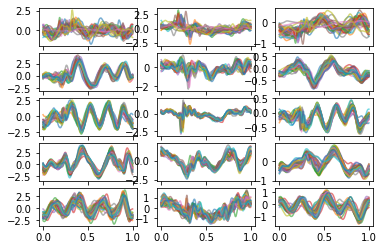

In [3]:
# Quick test plot
fig, ax = plt.subplots(len(runDates), 3, sharex=True)
for i,d in enumerate(runDates):
    dt = df.loc[df.date==d].copy()
    dt = dt.loc[dt.pulse==dt.pulse.iloc[0]]
    for j,m in enumerate(channelsFT[3:]):
        for jj in np.unique(dt['wb']):
            ax[i,j].plot(dt.loc[dt['wb']==jj, 'phase'], dt.loc[dt['wb']==jj, m], alpha=0.6)

# Torques in quiescent moth trials used to make COM translations
Works as a check to indicate that COM has been found: All torques plotted should be minimized to center around 0

[array([11.34315774, -1.99116011, 55.0768696 ]),
 array([ 4.90710636, -8.55999895, 57.73359689]),
 array([ 7.75505109, -5.84197762, 56.33163769]),
 array([ 8.18208076, -1.39892207, 55.71024836]),
 array([12.81044166, -2.61514537, 53.96501382])]

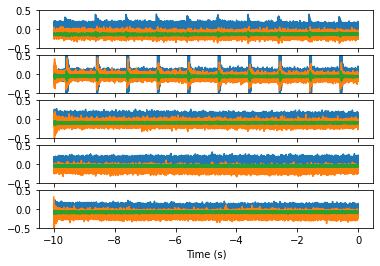

In [3]:
readFrom = 'dropbox'
fig, ax = plt.subplots(len(runDates), 1, sharex=True, sharey=True)
for ii,date in enumerate(runDates):
    # Read empty FT for bias
    biasmat, _, fsamp = readRaw(date, 'empty', doFT=True, readFrom=readFrom)
    bias = biasmat.mean(axis=0)[1:-1]
    # Use quiescent moth from stim characterization to find translation to COM
    charTrials = whichTrials(date, purpose='char', readFrom=readFrom)
    M, _, _ = readRaw(date, str(charTrials[0]).zfill(3), doFT=True, readFrom=readFrom)
    mat = M.mean(axis=0)[1:-1]
    # Apply calibration matrix and bias, get mean forces and torques for quiescent moth
    meanFT = transformFTdata((mat-bias).transpose(), M_trans=np.identity(6))
    lx,ly,lz = translations[runDates.index(date)].x
    lz = lz+20
    M_trans = np.array([
        [1,0,0,0,0,0],
        [0,1,0,0,0,0],
        [0,0,1,0,0,0],
        [0, lz, -ly, 1, 0, 0],
        [-lz, 0, lx, 0, 1, 0],
        [ly, -lx, 0, 0, 0, 1]
        ])
    new = transformFTdata((M[:,1:7]-bias).transpose(), M_trans=M_trans)
    for i in range(3):
        ax[ii].plot(M[:,0], new[:,3+i])
ax[len(runDates)-1].set_xlabel('Time (s)')
ax[0].set_ylim((-0.5,0.5))
[translations[i].x for i in range(len(runDates))]

# Stimulus phase vs spike times

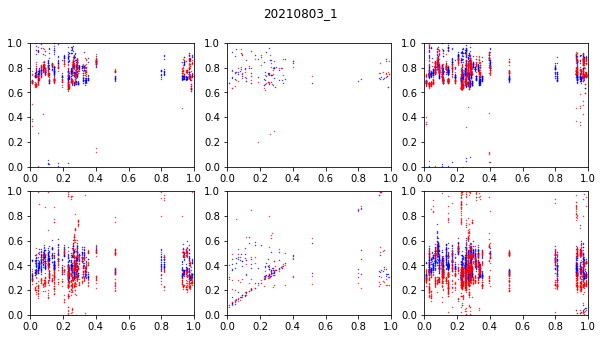

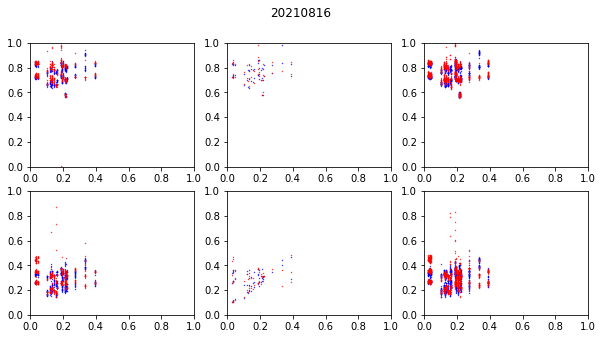

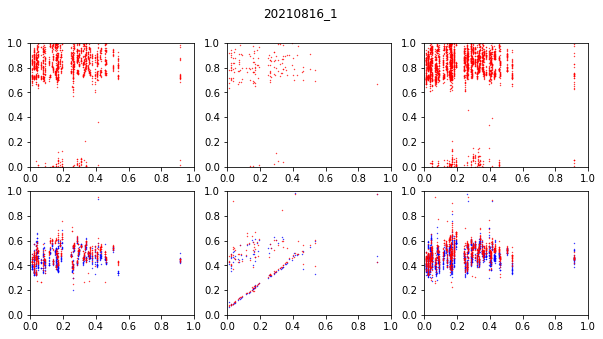

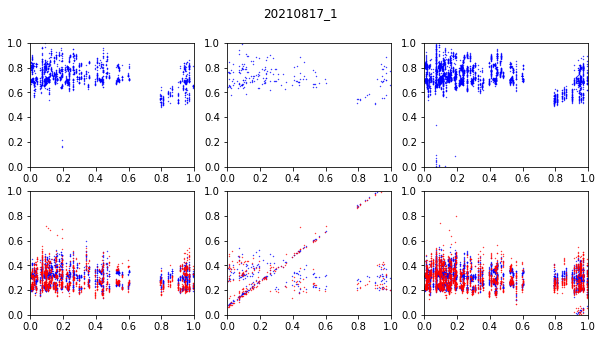

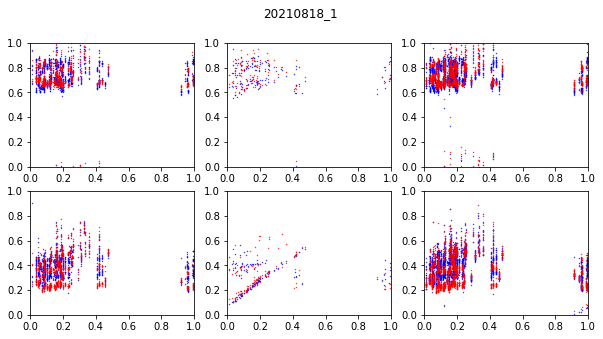

In [3]:
ms = 0.75
axnumbering = {'pre':0,'stim':1,'post':2}
for di,d in enumerate(runDates):
    fig, ax = plt.subplots(2, 3, figsize=(10,5))
    for name, g in df.loc[(df.date==d) & (df['LDVM_st'] | df['LDLM_st'] | df['RDLM_st'] | df['RDVM_st'])].groupby('wbstate'):
        i = axnumbering[name]
        # DVM subplot
        ax[0,i].plot(g.loc[g['LDVM_st'],'stimphase'], g.loc[g['LDVM_st'],'phase'], '.', color='blue', markersize=ms)
        ax[0,i].plot(g.loc[g['RDVM_st'],'stimphase'], g.loc[g['RDVM_st'],'phase'], '.', color='red', markersize=ms)
        # DLM subplot
        ax[1,i].plot(g.loc[g['LDLM_st'],'stimphase'], g.loc[g['LDLM_st'],'phase'], '.', color='blue', markersize=ms)
        ax[1,i].plot(g.loc[g['RDLM_st'],'stimphase'], g.loc[g['RDLM_st'],'phase'], '.', color='red', markersize=ms)
    for i,j in itertools.product(range(ax.shape[0]), range(ax.shape[1])):
        ax[i,j].set_xlim((0,1))
        ax[i,j].set_ylim((0,1))
    fig.suptitle(d)


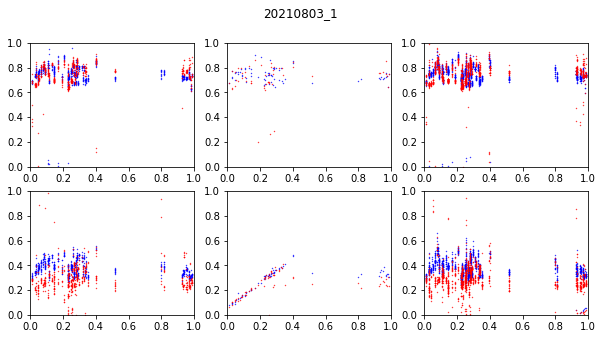

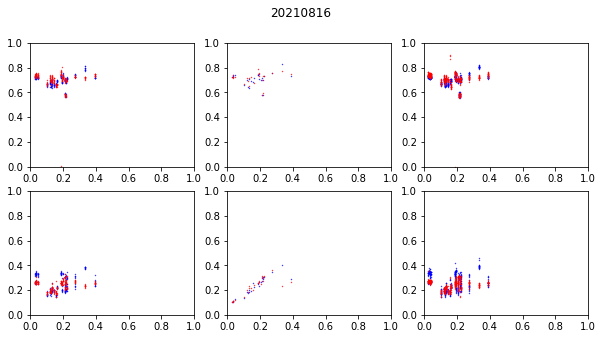

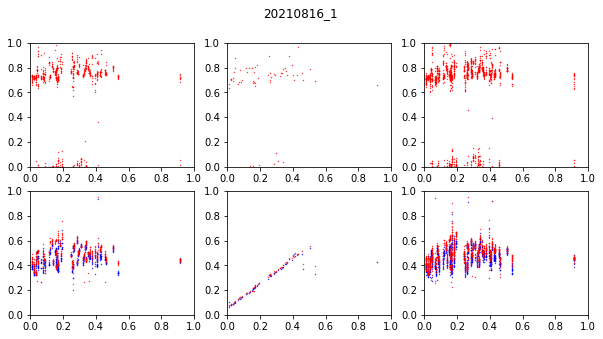

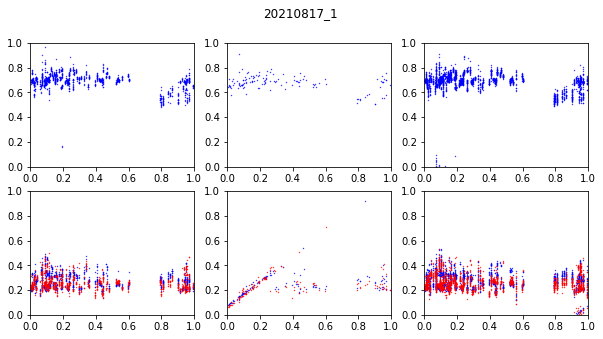

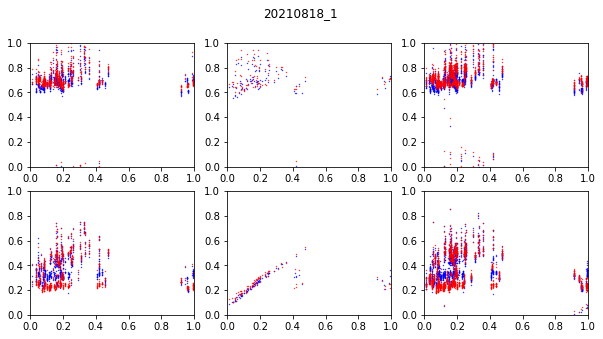

In [4]:
ms = 0.75
axnumbering = {'pre':0,'stim':1,'post':2}
aggdict = {'stimphase' : 'first'}
for m in channelsEMG:
    aggdict[m+'_fs'] = lambda x: x.iloc[0]/len(x)
for di,d in enumerate(runDates):
    fig, ax = plt.subplots(2, 3, figsize=(10,5))
    for name, g in df.loc[df.date==d].groupby('wbstate'):
        dt = g.groupby(['pulse','wb']).aggregate(aggdict)
        j = axnumbering[name]
        for m in channelsEMG:
            i = 0 if 'V' in m else 1
            col = 'blue' if m[0]=='L' else 'red'
            ax[i,j].plot(dt.loc[dt[m+'_fs']!=0,'stimphase'], dt.loc[dt[m+'_fs']!=0,m+'_fs'],
                         '.', color=col, markersize=ms)
    for i,j in itertools.product(range(ax.shape[0]), range(ax.shape[1])):
        ax[i,j].set_xlim((0,1))
        ax[i,j].set_ylim((0,1))
    fig.suptitle(d)


# Estimating "actual pitch" from pitch torque


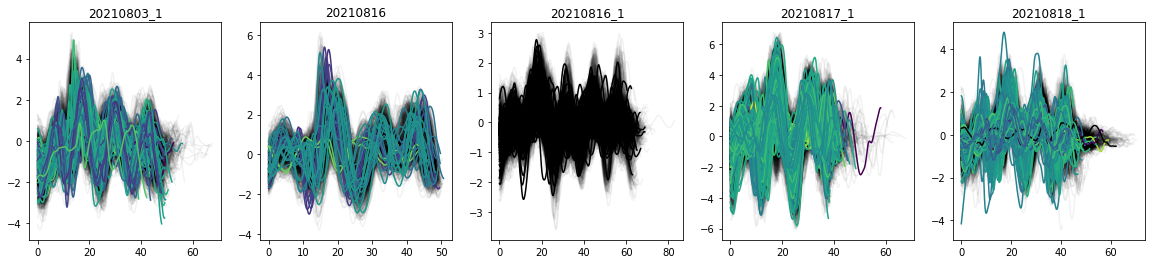

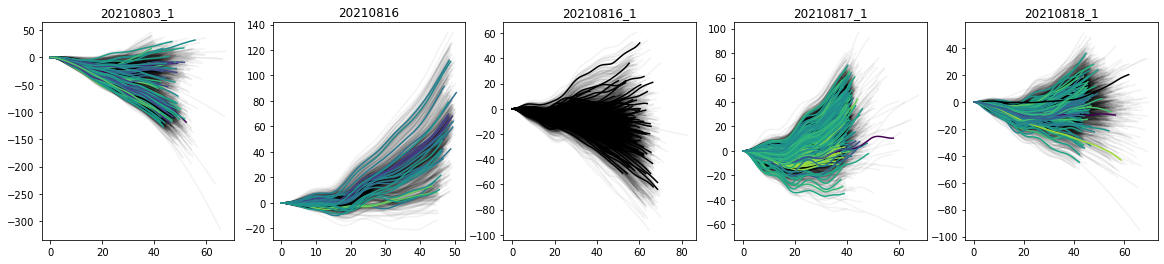

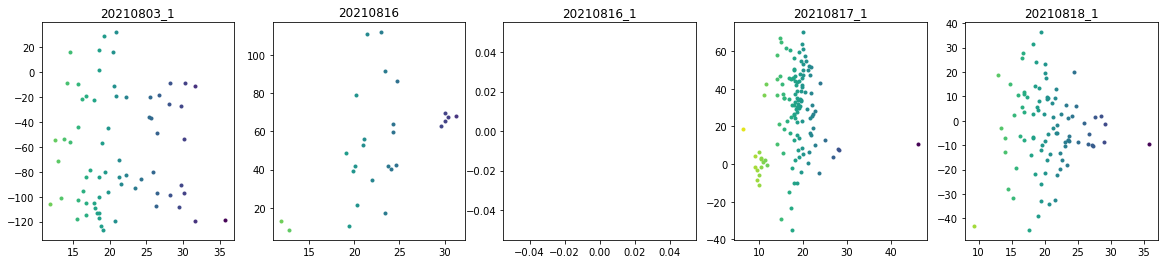

In [6]:
Iyy = 266.7*1e-09 # gmm^2 to kg m^2

figMoment, axMoment = plt.subplots(1, len(runDates), figsize=(20,4))
figTheta, axTheta = plt.subplots(1, len(runDates), figsize=(20,4))
figft, axft = plt.subplots(1, len(runDates), figsize=(20,4))
viridis = cmx.get_cmap('viridis')
mincol, maxcol = 5, 36

for i, (dname, dg) in enumerate(df.groupby('date')):
    for name, g in dg.groupby(['pulse','wb']):
        tvec = 1000*(g.Time - g.Time.iloc[0])
        # if len(g.loc[g['LDVM_st'], 'Time'])!=0:
        # tvec = 1000*(g.Time - g.loc[g['LDVM_st'], 'Time'].iloc[0])
        theta = cumtrapz(cumtrapz(g.mx/1000/Iyy, dx=1/fsamp), dx=1/fsamp)*180/np.pi
        thiswbstate = g.wbstate.iloc[0]
        if thiswbstate=='stim':
            yvar = g['tdl'].iloc[0]
            colvar = (maxcol - yvar)/(maxcol - mincol)
            axTheta[i].plot(tvec[:-2], theta, color=viridis(colvar), alpha=1, zorder=1)
            axMoment[i].plot(tvec, g.mx, color=viridis(colvar), alpha=1, zorder=1)
            axft[i].plot(yvar, theta[-1], '.', color=viridis(colvar))
        else:
            axTheta[i].plot(tvec[:-2], theta, color='black', alpha=0.05, zorder=0)
            axMoment[i].plot(tvec, g.mx, color='black', alpha=0.05, zorder=0)
    axTheta[i].set_title(dname)
    axMoment[i].set_title(dname)
    axft[i].set_title(dname)

# Phase-aligned vs. spike-aligned torque waveforms

Inspired by figure 2 of Simon's 2015 PLS paper; compare waveform alignment when aligned by wingbeat phase (zero crossing of hilbert transform) vs when aligned by first spike timing of a given muscle

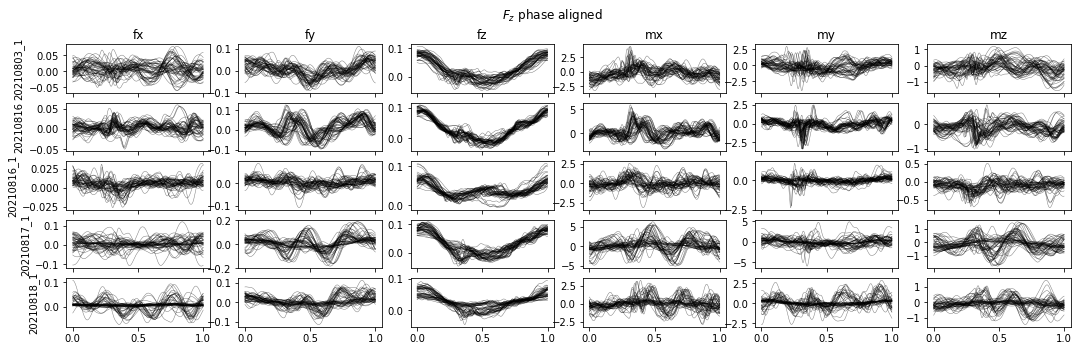

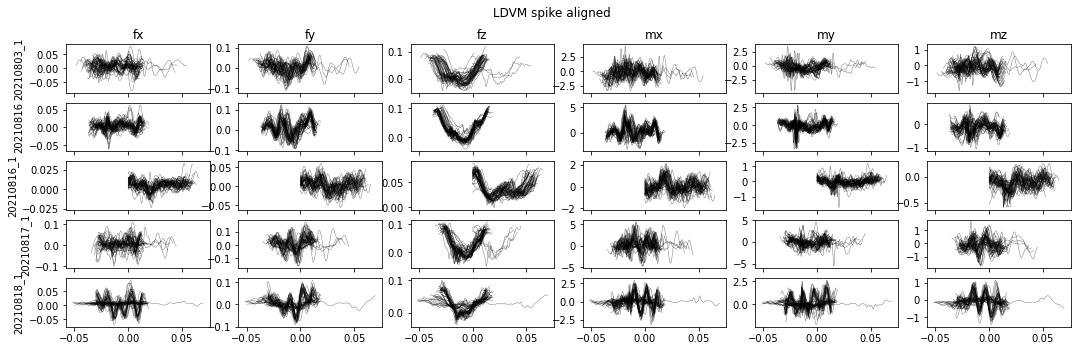

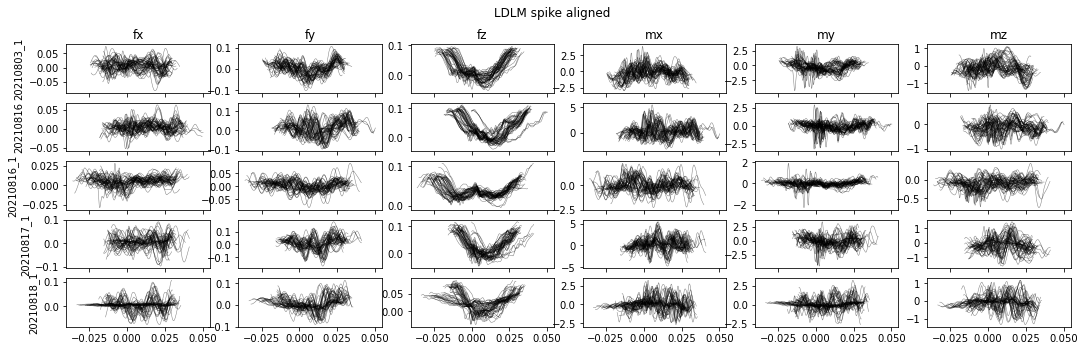

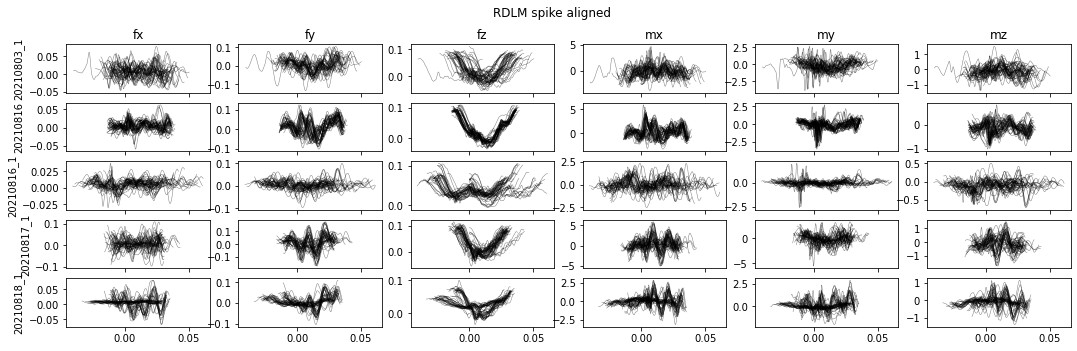

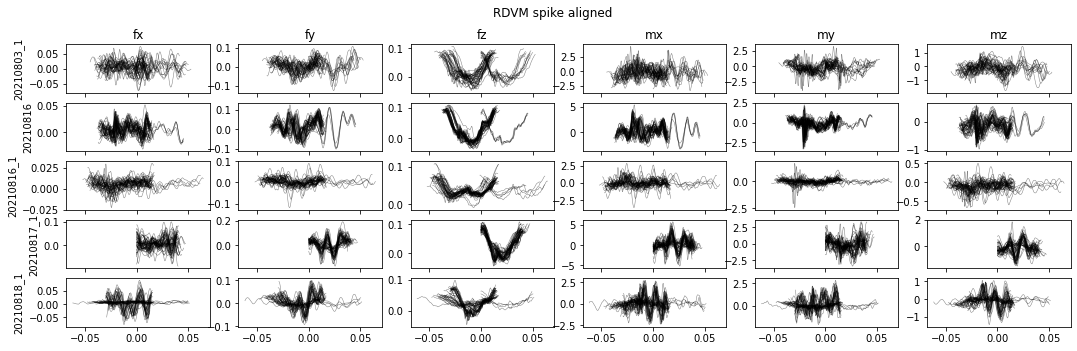

In [14]:
nwb = 50 # How many wingbeats to sample
fsize = (18, 5.2)

#--- Fz phase aligned
fig, ax = plt.subplots(len(runDates), len(channelsFT), figsize=fsize, sharex=True)
for i,d in enumerate(runDates):
    # grab this date
    dt = df.loc[(df.date==d) & (df.wb<-1),].copy()
    # Index the groups, select random subset
    g = dt.groupby(['pulse','wb'])
    a = np.arange(g.ngroups)
    np.random.shuffle(a)
    dt = dt[g.ngroup().isin(a[:nwb])]
    # Loop over randomly chosen groups and plotting variables, and plot
    for name, group in dt.groupby(['pulse','wb']):
        for j,m in enumerate(channelsFT):
            ax[i,j].plot(group.phase, group[m],
                         lw=0.5, alpha=0.5, color='black')
fig.suptitle(r'$F_z$ phase aligned')
for i,m in enumerate(channelsFT):
    ax[0,i].set_title(m)
for i,d in enumerate(runDates):
    ax[i,0].set_ylabel(d)

#--- First spike aligned
for alignMuscle in channelsEMG:
    fig, ax = plt.subplots(len(runDates), len(channelsFT), figsize=fsize, sharex=True)
    for i,d in enumerate(runDates):
        # Grab data
        dt = df.loc[(df.date==d) & (df.wb<-1) & (~np.isnan(df[alignMuscle+'_fs']))].copy()
        # Continue only if aligning muscle had data 
        if len(dt)!=0:
            # Index the groups, select random subset
            g = dt.groupby(['pulse','wb'])
            a = np.arange(g.ngroups)
            np.random.shuffle(a)
            dt = dt[g.ngroup().isin(a[:nwb])]
            # Loop over randomly chosen groups and plotting variables, and plot
            for name, group in dt.groupby(['pulse','wb']):
                for j,m in enumerate(channelsFT):
                    ax[i,j].plot(group.Time-group.Time.iloc[int(group[alignMuscle+'_fs'].iloc[0])],
                                group[m],
                                lw=0.5, alpha=0.5, color='black')
    fig.suptitle(alignMuscle+' spike aligned')
    for i,m in enumerate(channelsFT):
        ax[0,i].set_title(m)
    for i,d in enumerate(runDates):
        ax[i,0].set_ylabel(d)


# Mean waveforms sorted by $\Delta t$ decile
General method for taking a start point (spike triggered, stim triggered, wingbeat, etc), a separating variable (like mean torque, or induced spike time difference), and plotting mean torque traces over time, binned by decile of separating variable

processing and plotting 20210803_1
processing and plotting 20210816
processing and plotting 20210816_1
processing and plotting 20210817_1
processing and plotting 20210818_1


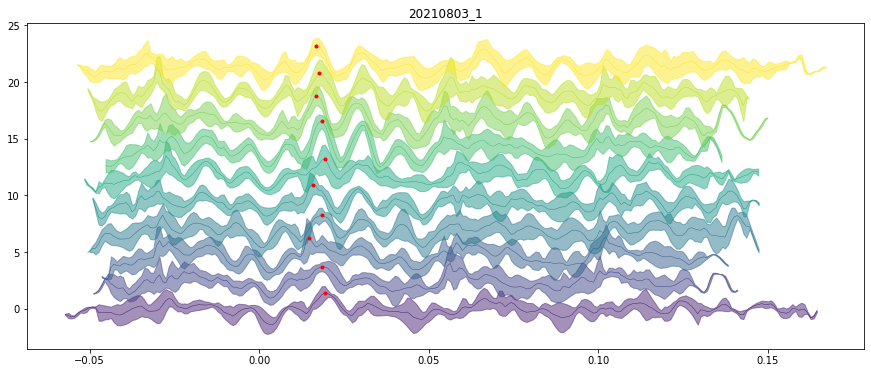

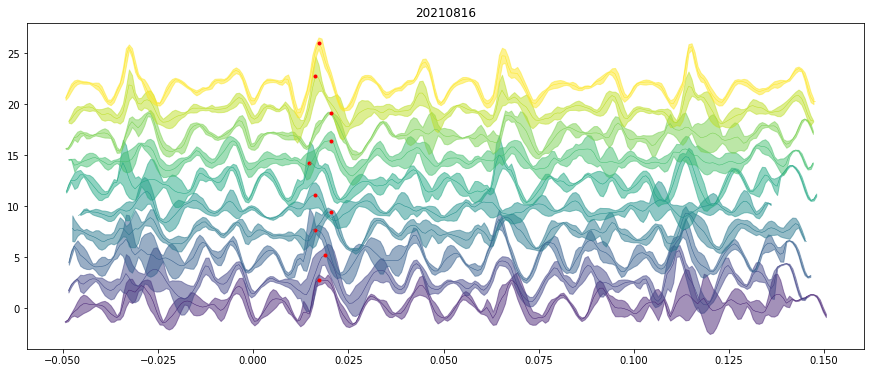

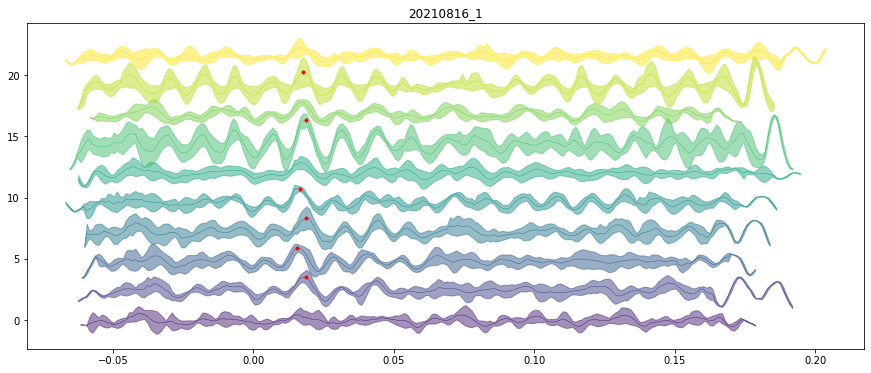

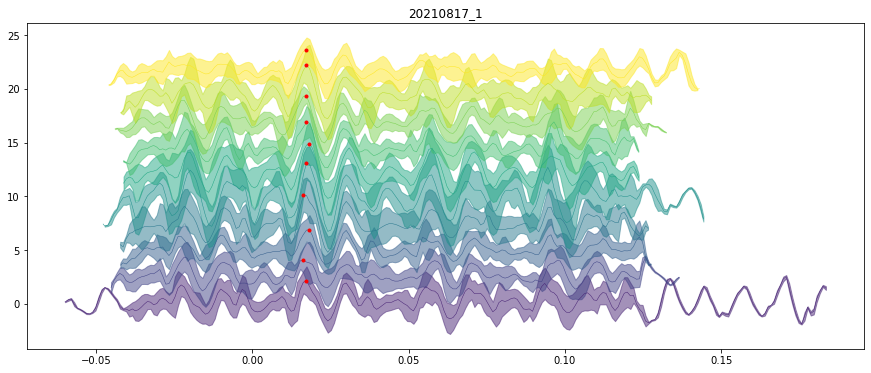

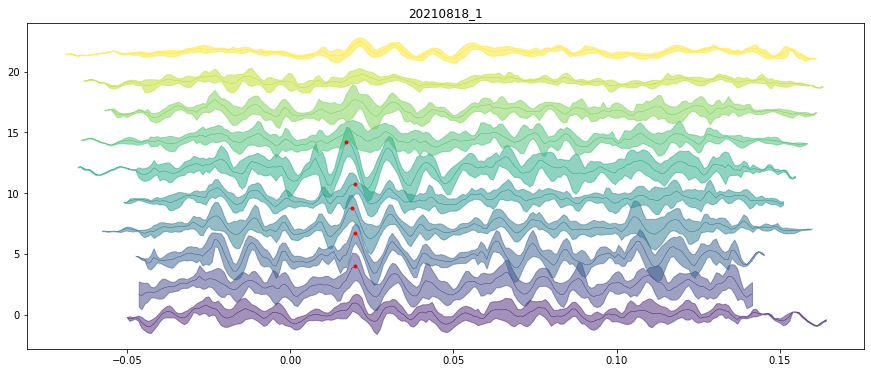

In [7]:
usewb = (-1, 3) # ignore all wingbeat except in this range
ngridx = 250
sep = 2.4 # amount to separate mean traces by 

viridis = cmx.get_cmap('viridis')
# Loop over dates
for di,d in enumerate(runDates):
    print('processing and plotting '+d)
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimphase<0.5)].copy()
    # Zero time, trim data to region around t=0, change phase to be unique for each wb
    dt.Time = dt.groupby(['date','pulse'], group_keys=False).apply(
        lambda g: g['Time'] - g.loc[(g.wb==0), 'Time'].iloc[0])
        # lambda g: g['Time'] - (g.loc[(g.wb==-1), 'Time'].iloc[0] + g.loc[g.wb==-1,'LDVM_fs'].iloc[0]/fsamp))
    dt.phase = dt.phase + dt.wb
    # Generate y axis vector
    dt['yvar'] = 0
    dt['td'] = np.where(np.isnan(dt['tdl']), dt['tdr'], dt['tdl'])
    dt['yvar'] = dt.groupby(['date','pulse'], group_keys=False).apply(
        lambda g: g.yvar + (g.loc[g.wbstate=='stim', 'td'].iloc[0] - g.loc[g.wb==-1, 'td'].iloc[0]))
        # lambda g: g.yvar + g.loc[g.wbstate=='stim', 'td'].iloc[0])
        # lambda g: g.yvar + (g.loc[g.wbstate=='stim', 'LDVM_fs'].iloc[0] - g.loc[g.wbstate=='stim', 'LDLM_fs'].iloc[0])/len(g.loc[g.wbstate=='stim']))
    dt = dt.loc[~np.isnan(dt.yvar)]
    # Split by deciles
    dec = np.percentile(dt.yvar, np.arange(0, 100, 10))
    dt['dec'] = np.digitize(dt.yvar, dec)
    # Get mean waveforms for each decile
    # xl,yl,gl = binPlot(dt, 'phase', ['mx'], 'dec', 'dec', ngridx+1, makeplot=False)
    xl,yl,gl = binPlot(dt, 'Time', ['mx'], 'dec', 'dec', ngridx+1, makeplot=False)
    
    # Waveform plots
    plt.figure(figsize=(15,6))
    for i in range(len(xl)):
        plt.fill_between(xl[i]['mean'],
                         sep*i + yl[i]['mean'] - yl[i]['std'],
                         sep*i + yl[i]['mean'] + yl[i]['std'],
                         color=viridis(gl[i]/np.max(gl)),
                         alpha=0.5)
        plt.plot(xl[i]['mean'], sep*i + yl[i]['mean'], color=viridis(gl[i]/np.max(gl)), lw=0.5)
        
        # inds = (xl[i]['mean'] > 0.2) & (xl[i]['mean'] < 0.6)
        inds = (xl[i]['mean'] > 0) & (xl[i]['mean'] < 0.025)
        j = find_peaks(yl[i]['mean'][inds], height=1, distance=100)[0]
        plt.plot(xl[i]['mean'][inds].iloc[j], sep*i + yl[i]['mean'][inds].iloc[j], 'r.')
    plt.title(d)

# Peak location against stimulation variables (didn't pan out)

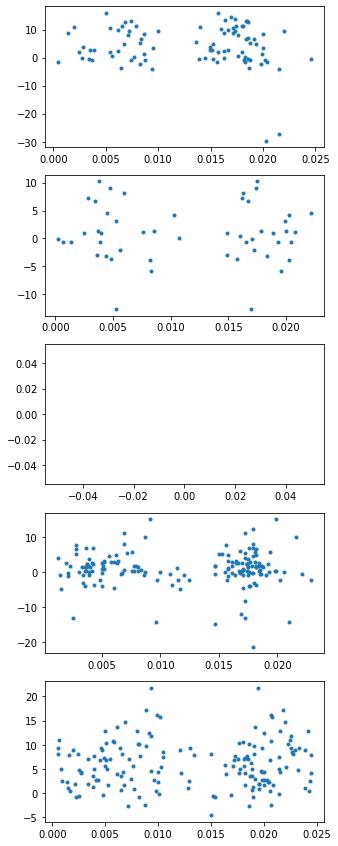

In [20]:
usewb = (-1, 1) # ignore all wingbeat except in this range

# make dataframe subset
dt = df.loc[(df.wb>=usewb[0]) & 
            (df.wb<usewb[1]) & 
            (df.stimphase<0.5)].copy()
# Zero time, trim data to region around t=0, change phase to be unique for each wb
dt.Time = dt.groupby(['date','pulse'], group_keys=False).apply(
    lambda g: g['Time'] - g.loc[(g.wb==0), 'Time'].iloc[0])
    # lambda g: g['Time'] - (g.loc[(g.wb==-1), 'Time'].iloc[0] + g.loc[g.wb==-1,'LDVM_fs'].iloc[0]/fsamp))
dt.phase = dt.phase + dt.wb
# Generate y axis vector
dt['yvar'] = 0
dt['td'] = np.where(np.isnan(dt['tdl']), dt['tdr'], dt['tdl'])
dt['yvar'] = dt.groupby(['date','pulse'], group_keys=False).apply(
    lambda g: g.yvar + (g.loc[g.wbstate=='stim', 'td'].iloc[0] - g.loc[g.wb==-1, 'td'].iloc[0]))
    # lambda g: g.yvar + g.loc[g.wbstate=='stim', 'td'].iloc[0])
dt = dt.loc[~np.isnan(dt.yvar)]

# Grab first peak in desired range
# dt = dt.loc[(dt.phase>0.2) & (dt.phase<0.5)].groupby(['date','pulse']).apply(
dt = dt.loc[(dt.Time>0) & (dt.Time<0.025)].groupby(['date','pulse']).apply(
    lambda g: g.iloc[find_peaks(g.mx, distance=100)[0]])

# Split by deciles
dec = np.percentile(dt.yvar, np.arange(0, 100, 10))
dt['dec'] = np.digitize(dt.yvar, dec)

# Plot peak location against yvar
fig, ax = plt.subplots(len(runDates), 1, figsize=(5,15))
for di, d in enumerate(runDates):
    dtsub = dt.loc[dt.date==d]
    # ax[di].plot(dtsub.phase, dtsub.yvar, '.')
    ax[di].plot(dtsub.Time, dtsub.yvar, '.')


# PCA on Deciles

- Treat individual as a column/variable of the data, do a unified approach


processing 20210803_1
processing 20210816
processing 20210816_1
processing 20210817_1
processing 20210818_1


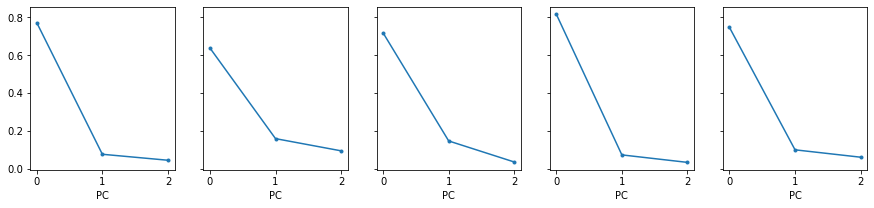

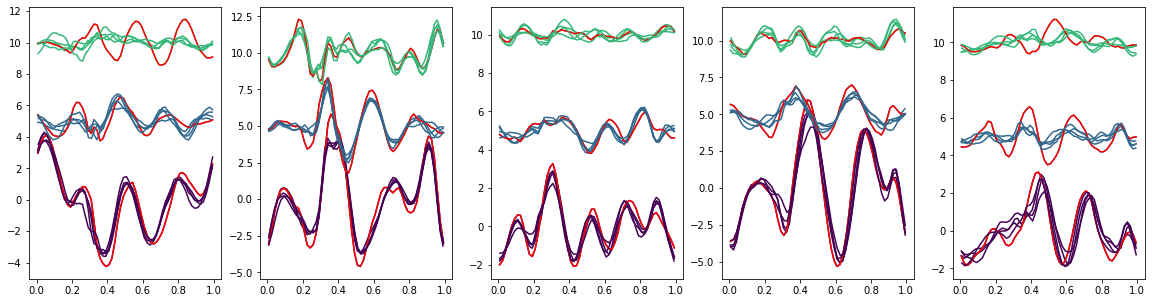

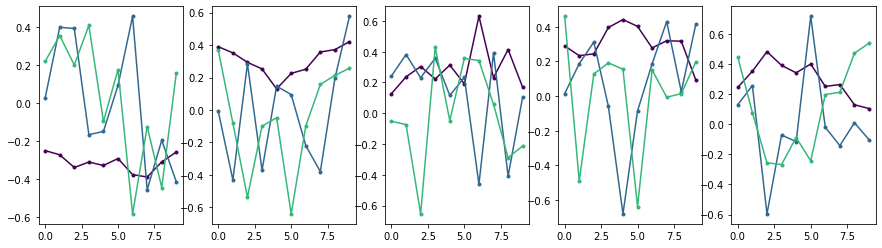

In [127]:
usewb = (-2, 3) # ignore all wingbeat except in this range
usewindow = (-200, 200) # ms, window to actually observe around zero'd time
ncomp = 3
ngridx = 300

figev, axev = plt.subplots(1, len(runDates), figsize=(15,3), sharey=True) # explained variance figure
figpc, axpc = plt.subplots(1, len(runDates), figsize=(20,5)) # Main PC traces
figload, axload = plt.subplots(1, len(runDates), figsize=(15,4)) # PC loadings
viridis = cmx.get_cmap('viridis')

# Loop over dates
for di,d in enumerate(runDates):
    print('processing ' + d)
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimphase<0.5)].copy()
    # Zero time, trim data to region around t=0, change phase to be unique for each wb
    dt.Time = dt.groupby(['date','pulse'], group_keys=False).apply(
        lambda g: g['Time'] - g.loc[(g.wb==0), 'Time'].iloc[0])
        # lambda g: g['Time'] - (g.loc[(g.wb==-1), 'Time'].iloc[0] + g.loc[g.wb==-1,'LDVM_fs'].iloc[0]/fsamp))
    dt = dt.loc[(dt.Time>=usewindow[0]/1000) & (dt.Time<=usewindow[1]/1000)]
    dt.phase = dt.phase + dt.wb
    # Generate y axis vector
    dt['yvar'] = 0
    dt['td'] = np.where(np.isnan(dt['tdl']), dt['tdr'], dt['tdl'])
    dt['yvar'] = dt.groupby(['date','pulse'], group_keys=False).apply(
        lambda g: g.yvar + (g.loc[g.wbstate=='stim', 'td'].iloc[0] - g.loc[g.wb==-1, 'td'].iloc[0]))
        # lambda g: g.yvar + g.loc[g.wbstate=='stim', 'td'].iloc[0])
        # lambda g: g.yvar + (g.loc[g.wbstate=='stim', 'LDVM_fs'].iloc[0] - g.loc[g.wbstate=='stim', 'LDLM_fs'].iloc[0])/len(g.loc[g.wbstate=='stim']))
    dt = dt.loc[~np.isnan(dt.yvar)]
    
    # Split by deciles
    dec = np.percentile(dt.yvar, np.arange(0, 100, 10))
    dt['dec'] = np.digitize(dt.yvar, dec)
    # Get mean waveforms for each decile
    xl,yl,gl = binPlot(dt, 'phase', ['mx'], 'dec', 'dec', ngridx+1, makeplot=False)
    
    # Put into PCA matrix
    mat = np.vstack([yl[i]['mean'] for i in range(len(yl))]).T
    # Run PCA
    pca = PCA(n_components=ncomp)
    pc = pca.fit_transform(mat)
    
    # Plot PCA explained variance
    axev[di].plot(pca.explained_variance_ratio_, '.-')
    axev[di].set_xlabel('PC')
    # Plot main PC's
    # for i in range(ncomp):
    #     axpc[di].plot(xl[i]['mean'], pc[:,i]+i*5, color=viridis(i/pc.shape[1]))
    for i in range(ncomp):
        for j in np.arange(usewb[0],usewb[1]):
            inds = (xl[i]['mean']<(j+1)) & (xl[i]['mean']>j)
            axpc[di].plot(xl[i]['mean'][inds]-j, pc[inds,i]+i*5, color=viridis(i/pc.shape[1]))
            if j==0:
                axpc[di].plot(xl[i]['mean'][inds]-j, pc[inds,i]+i*5, color='red')
    # Plot loadings of each PC against decile
    for i in range(ncomp):
        axload[di].plot(np.arange(len(xl)), pca.components_[i,:], '.-', color=viridis(i/ncomp))

## PCA as above, but not separated by individual

[0.9508953034943658, 0.9352569830634483, 0.5664015880680469]
[15.338984072271677, 4.859069669960045, 6.995125479457327]


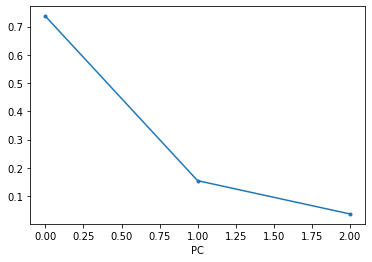

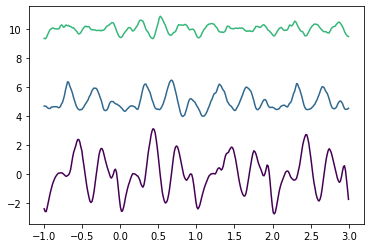

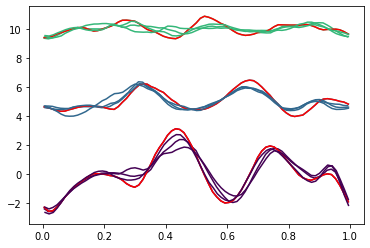

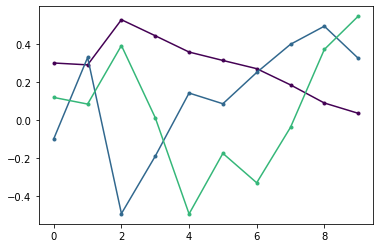

In [12]:
usewb = (-1, 3) # ignore all wingbeat except in this range
ncomp = 3
ngridx = 300

viridis = cmx.get_cmap('viridis')

# make dataframe subset
dt = df.loc[(df.date!='20210816') &
            (df.wb>=usewb[0]) & 
            (df.wb<usewb[1]) & 
            (df.stimphase<0.5)].copy()
# Zero time, trim data to region around t=0, change phase to be unique for each wb
dt.Time = dt.groupby(['date','pulse'], group_keys=False).apply(
    lambda g: g['Time'] - g.loc[(g.wb==0), 'Time'].iloc[0])
    # lambda g: g['Time'] - (g.loc[(g.wb==-1), 'Time'].iloc[0] + g.loc[g.wb==-1,'LDVM_fs'].iloc[0]/fsamp))
dt.phase = dt.phase + dt.wb
# Generate y axis vector
dt['yvar'] = 0
dt['td'] = np.where(np.isnan(dt['tdl']), dt['tdr'], dt['tdl'])
dt['yvar'] = dt.groupby(['date','pulse'], group_keys=False).apply(
    lambda g: g.yvar + (g.loc[g.wbstate=='stim', 'td'].iloc[0] - g.loc[g.wb==-1, 'td'].iloc[0]))
    # lambda g: g.yvar + g.loc[g.wbstate=='stim', 'td'].iloc[0])
    # lambda g: g.yvar + (g.loc[g.wbstate=='stim', 'LDVM_fs'].iloc[0] - g.loc[g.wbstate=='stim', 'LDLM_fs'].iloc[0])/len(g.loc[g.wbstate=='stim']))
dt = dt.loc[~np.isnan(dt.yvar)]

# Split by deciles
dec = np.percentile(dt.yvar, np.arange(0, 100, 10))
dt['dec'] = np.digitize(dt.yvar, dec)
# Get mean waveforms for each decile
xl,yl,gl = binPlot(dt, 'phase', ['mx'], 'dec', 'dec', ngridx+1, makeplot=False)

# Put into PCA matrix
mat = np.vstack([yl[i]['mean'] for i in range(len(yl))]).T
# Run PCA
pca = PCA(n_components=ncomp)
pc = pca.fit_transform(mat)

# Plot PCA explained variance
plt.figure()
plt.plot(pca.explained_variance_ratio_, '.-')
plt.xlabel('PC')
# Plot main PC's
plt.figure()
for i in range(ncomp):
    plt.plot(xl[i]['mean'], pc[:,i]+i*5, color=viridis(i/pc.shape[1]))
# Plot main PC's folded so wingbeats overlap
plt.figure()
xPC = []
yPC = []
for i in range(ncomp):
    xPC.append([])
    yPC.append([])
    for j in np.arange(usewb[0],usewb[1]):
        inds = (xl[i]['mean']<=(j+1)) & (xl[i]['mean']>=j)
        xPC[i].append(xl[i]['mean'][inds]-j)
        yPC[i].append(pc[inds,i])
        plt.plot(xl[i]['mean'][inds]-j, pc[inds,i]+i*5, color=viridis(i/pc.shape[1]))
        if j==0:
            plt.plot(xl[i]['mean'][inds]-j, pc[inds,i]+i*5, color='red')
# Plot loadings of each PC against decile
plt.figure()
for i in range(ncomp):
    plt.plot(np.arange(len(xl)), pca.components_[i,:], '.-', color=viridis(i/ncomp))

print([np.corrcoef(yPC[i][0],yPC[i][1])[0,1] for i in range(ncomp)])
print([np.sum((yPC[i][0] - yPC[i][1])**2) for i in range(ncomp)])

# PLS and CCA Data Setup

In [159]:
phaseOrTime = 'phase'
usewb = (-2,2)
phaseSamples = 300 # total samples to interpolate for phase
timeWindow = (0,500) # samples (before t=0, after t=0)

# make dataframe subset
dt = df.loc[(df.date!='20210816') & 
            (df.wb>=usewb[0]) & 
            (df.wb<usewb[1]) & 
            (df.stimphase<0.5)].copy()
# Zero time, trim data to region around t=0, change phase to be unique for each wb
dt.Time = dt.groupby(['date','pulse'], group_keys=False).apply(
    lambda g: g['Time'] - g.loc[(g.wb==0), 'Time'].iloc[0])
    # lambda g: g['Time'] - (g.loc[(g.wb==-1), 'Time'].iloc[0] + g.loc[g.wb==-1,'LDVM_fs'].iloc[0]/fsamp))
# Generate stimulation variable vector
dt['yvar'] = 0
dt['td'] = np.where(np.isnan(dt['tdl']), dt['tdr'], dt['tdl'])
dt['yvar'] = dt.groupby(['date','pulse'], group_keys=False).apply(
    lambda g: g.yvar + (g.loc[g.wbstate=='stim', 'td'].iloc[0] - g.loc[g.wb==-1, 'td'].iloc[0]))
    # lambda g: g.yvar + g.loc[g.wbstate=='stim', 'td'].iloc[0])
# Filtering
dt = dt.loc[~np.isnan(dt.yvar)] # bad stim variable
dt.phase = dt.wb + dt.phase # set phase to continuously increase
# Remove any pulses that lack the full wingbeat range
if phaseOrTime=='phase':
    dt = dt.groupby(['date','pulse']).filter(lambda g: (g.wb.iloc[0]==usewb[0]) & (g.wb.iloc[-1]==usewb[1]-1))
# TODO: Write the time version

# Create grouped df
dtgroup = dt.groupby(['date','pulse'])
# Prep by getting dimensions of matrices (how many observations)
n = len(dtgroup.groups.keys())

# Generate X
if phaseOrTime=='Time': # Use Time as X, pass a simple window
    X = np.zeros((n,sum(timeWindow)))
    for i, (name, g) in enumerate(dtgroup):
        index0 = (g.Time==0).idxmax()
        X[i,:] = g.loc[(index0-timeWindow[0]):(index0+timeWindow[1]), 'mx']
else: # Use phase as X, forced to interpolate
    X = np.zeros((n,phaseSamples))
    xInterpAt = np.linspace(usewb[0], usewb[1], phaseSamples)
    for i, (name, g) in enumerate(dtgroup):
        interpfunc = interp1d(g.phase, g['mx'], kind='linear')
        X[i,:] = interpfunc(xInterpAt)
# Generate Y
# Y = dtgroup.aggregate({'yvar':'first'}).to_numpy()
def aggfunc(g):
    x = [
        g.yvar.iloc[0],
        g.loc[g.wb==-1,'td'].iloc[0],
        g.loc[g.wb==0,'td'].iloc[0],
        fsamp/len(g.loc[g.wb==-1]),
        g.trial.iloc[0]
        ]
    return x
Y = np.vstack(dtgroup.apply(aggfunc).reset_index()[0].to_numpy())

dateRows = np.ravel(dtgroup.aggregate({'date':'first'}).to_numpy())

Text(0.5, 0.04, 'Data projected onto first component')

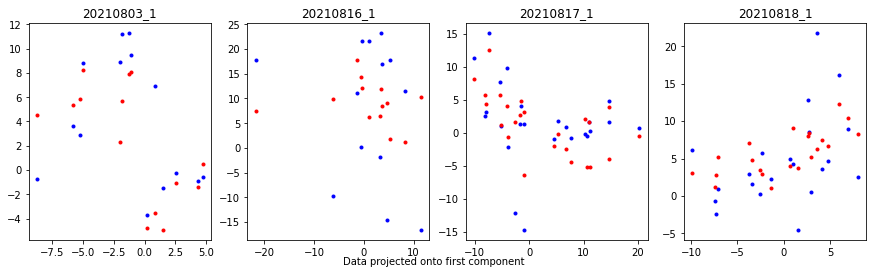

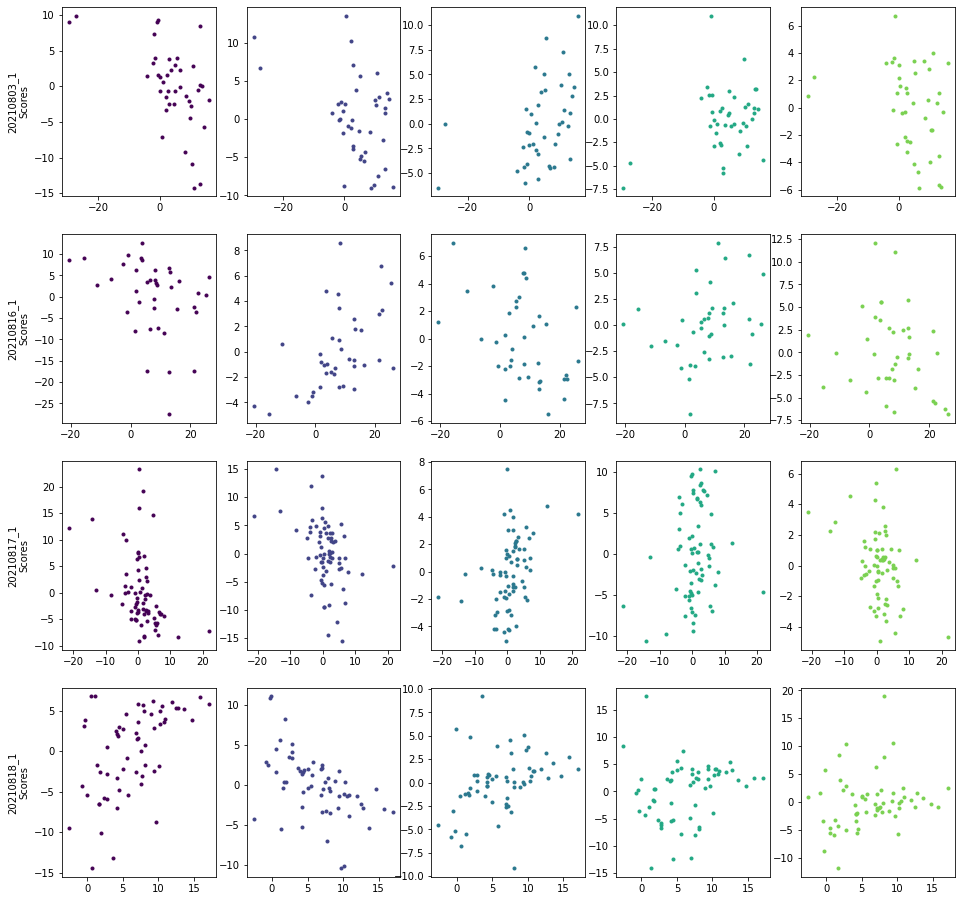

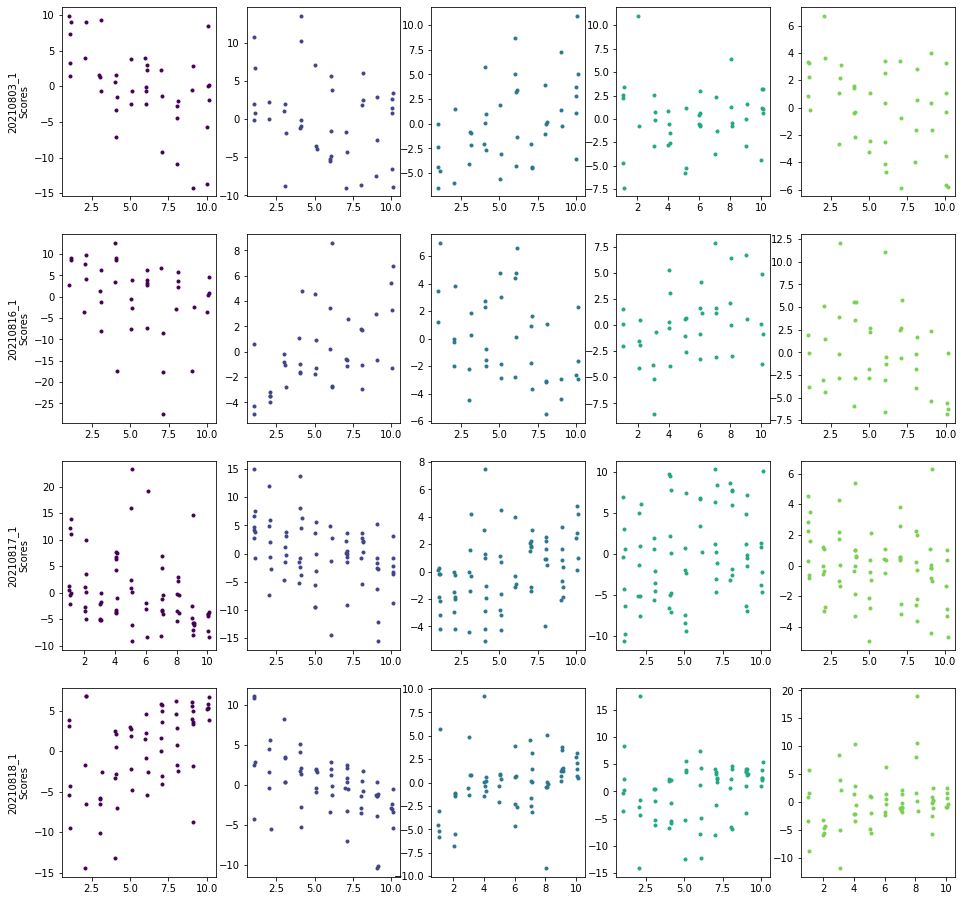

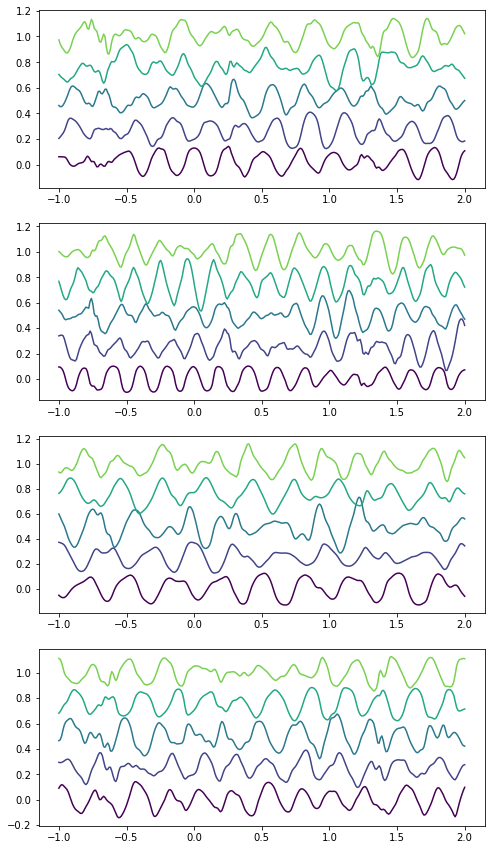

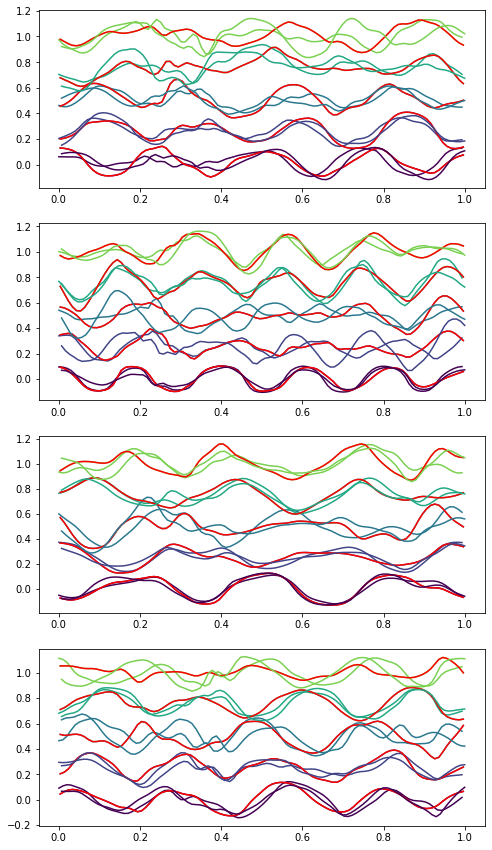

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [83]:
ncomp = 5
rng = np.random.RandomState(0)

viridis = cmx.get_cmap('viridis')
figtraintest, axtraintest = plt.subplots(1, len(runDates), figsize=(15,4)) # train-test validation
figScore, axScore = plt.subplots(len(runDates), ncomp, figsize=(16,16)) # feature scores against stim variable
figScoreDec, axScoreDec = plt.subplots(len(runDates), ncomp, figsize=(16,16)) # feature scores against deciles of stim variable
figFeat, axFeat = plt.subplots(len(runDates), 1, figsize=(8,15))
figFeatStack, axFeatStack = plt.subplots(len(runDates), 1, figsize=(8,15))

# Loop over dates
for di, d in enumerate(runDates):
    # Get values for this individual
    thisX, thisY = X[np.ravel(dateRows==d),:], Y[dateRows==d]
    # Train and test split
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(thisX, thisY, random_state=rng)
    # Deciles of stim timing
    decbins = np.percentile(thisY, np.arange(0, 100, 10))
    dec = np.digitize(Ytrain, decbins)
    
    # Fit PLS Regression!
    pls = PLSRegression(n_components=ncomp)
    pls.fit(Xtrain, Ytrain)
    
    #--- PLOTS
    # Cross-validate with train/test split
    axtraintest[di].plot(pls.transform(Xtest)[:,0], Ytest, 'b.', label='ground truth')
    axtraintest[di].plot(pls.transform(Xtest)[:,0], pls.predict(Xtest), 'r.', label='prediction')
    axtraintest[di].set_title(d)
    # Plot x scores against stim timing Y/output variable
    for i in range(pls.n_components):
        axScore[di,i].plot(Ytrain, pls.x_scores_[:,i], '.', color=viridis(i/pls.n_components))
    # X scores against decile of stim timing
    for i in range(pls.n_components):
        axScoreDec[di,i].plot(dec + 0.15*np.random.rand(len(dec)),
                              pls.x_scores_[:,i],
                              '.', color=viridis(i/pls.n_components))
    axScore[di,0].set_ylabel(d + "\n""Scores")
    axScoreDec[di,0].set_ylabel(d + "\n""Scores")
    # Plot features
    plt.figure()
    for i in range(pls.n_components):
        axFeat[di].plot(xInterpAt, 0.25*i + pls.x_loadings_[:,i], color=viridis(i/pls.n_components))
    # Plot features overlaid cycle-on-cycle
    xfeat = []
    features = []
    for i in range(pls.n_components):
        xfeat.append([])
        features.append([])
        for j in np.arange(usewb[0],usewb[1]):
            inds = (xInterpAt<=(j+1)) & (xInterpAt>=j)
            xfeat[i].append(xInterpAt[inds]-j)
            features[i].append(pls.x_loadings_[inds,i])
            axFeatStack[di].plot(xInterpAt[inds]-j, 0.25*i + pls.x_loadings_[inds,i], color=viridis(i/pls.n_components))
            if j==0:
                axFeatStack[di].plot(xInterpAt[inds]-j, 0.25*i + pls.x_loadings_[inds,i], color='red')
    # print([np.corrcoef(features[i][0],features[i][1])[0,1] for i in range(pls.n_components)])
    # print([np.sum((features[i][0] - features[i][1])**2) for i in range(pls.n_components)])
# Labels
figtraintest.text(0.5, 0.04, 'Data projected onto first component', ha='center')

# CCA 

/Users/leo/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:271: UserWarning: Y residual is constant at iteration 4
  warnings.warn(f"Y residual is constant at iteration {k}")
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:271: UserWarning: Y residual is constant at iteration 4
  warnings.warn(f"Y residual is constant at iteration {k}")
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:271: UserWarning: Y residual is constant at iteration 4
  warnings.warn(f"Y residual is constant at iteration {k}")


Text(0.5, 0.04, 'Data projected onto first component')

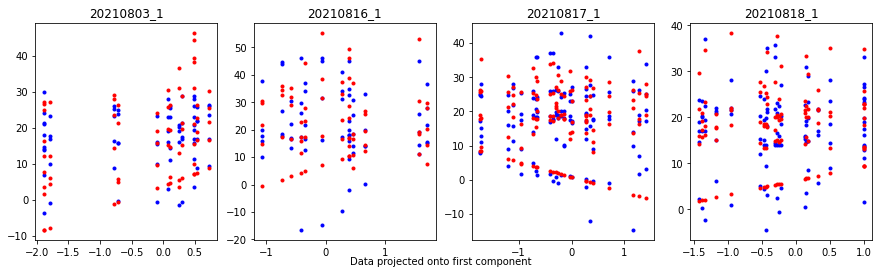

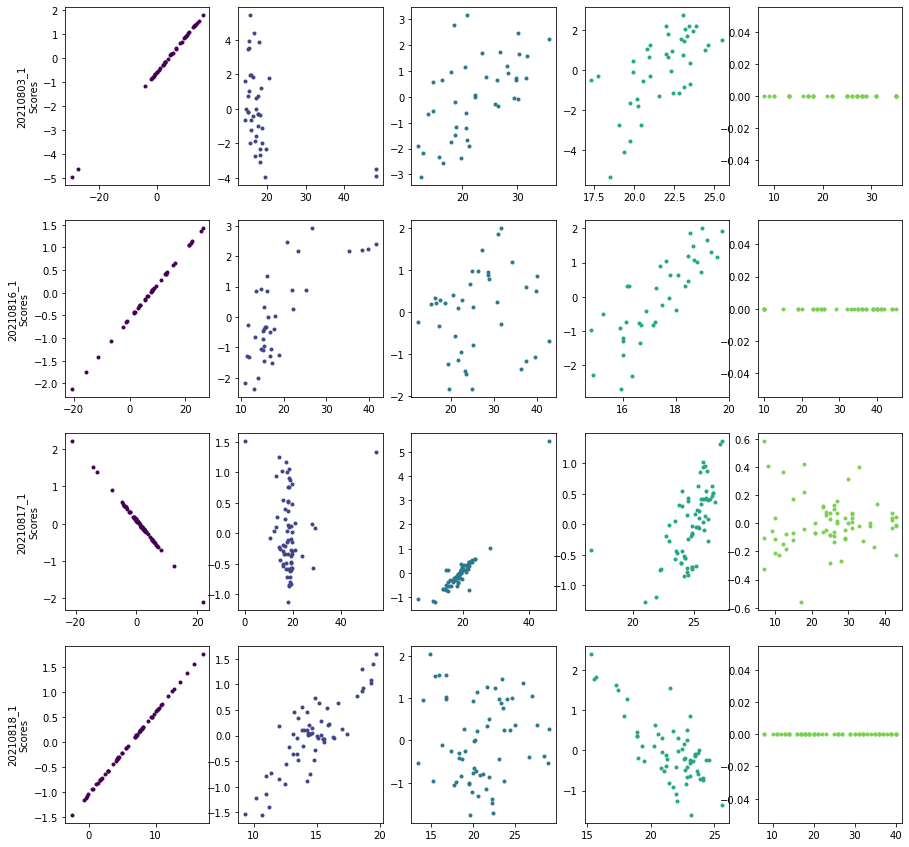

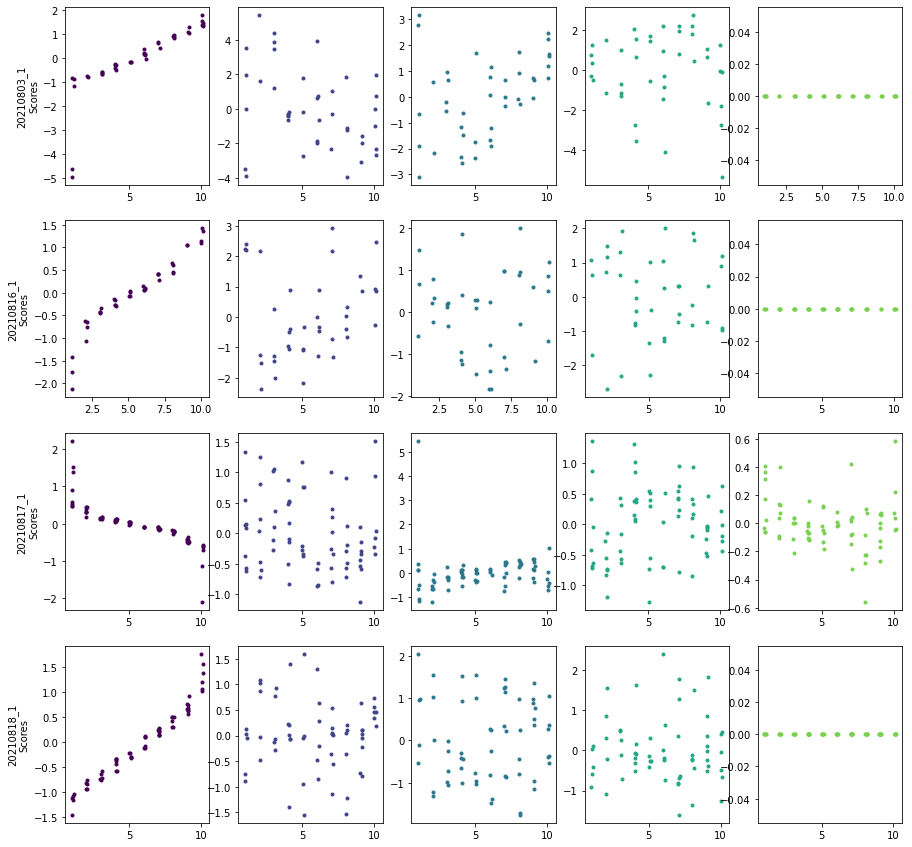

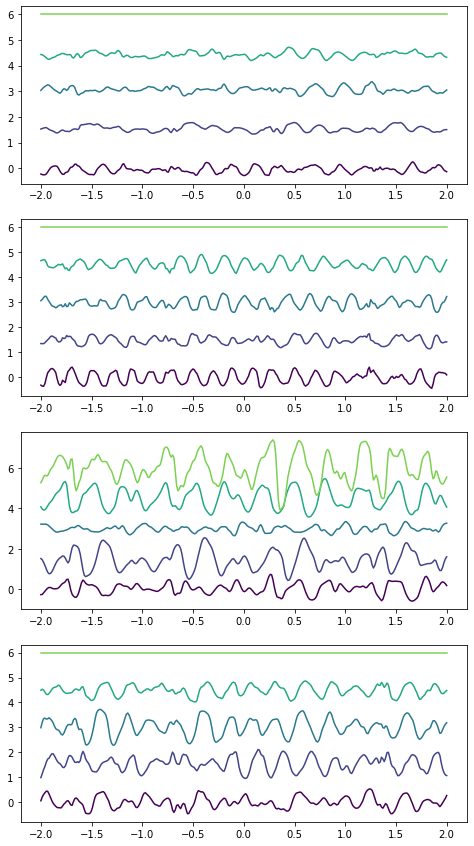

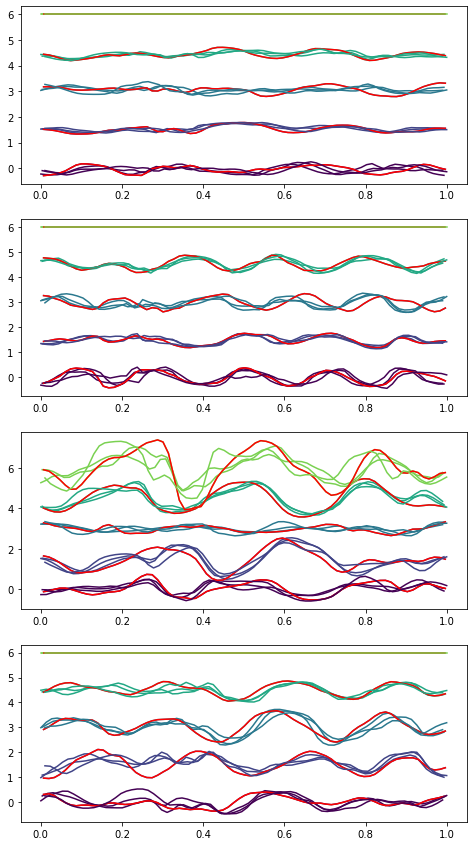

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [161]:
ncomp = Y.shape[1]
sep = 1.5
rng = np.random.RandomState(0)

viridis = cmx.get_cmap('viridis')
figtraintest, axtraintest = plt.subplots(1, len(runDates), figsize=(15,4)) # train-test validation
figScore, axScore = plt.subplots(len(runDates), ncomp, figsize=(3*ncomp,15)) # feature scores against stim variable
figScoreDec, axScoreDec = plt.subplots(len(runDates), ncomp, figsize=(3*ncomp,15)) # feature scores against deciles of stim variable
figFeat, axFeat = plt.subplots(len(runDates), 1, figsize=(8,15))
figFeatStack, axFeatStack = plt.subplots(len(runDates), 1, figsize=(8,15))

# Loop over dates
for di, d in enumerate(runDates):
    # Get values for this individual
    thisX, thisY = X[dateRows==d,:], Y[dateRows==d,:]
    # Train and test split
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(thisX, thisY, random_state=rng)
    # Deciles of stim timing
    decbins = np.percentile(thisY[:,0], np.arange(0, 100, 10))
    dec = np.digitize(Ytrain[:,0], decbins)
    
    # Fit CCA!
    cca = CCA(n_components=ncomp)
    cca.fit(Xtrain, Ytrain)
    
    #--- PLOTS
    # Cross-validate with train/test split
    axtraintest[di].plot(cca.transform(Xtest)[:,0], Ytest, 'b.', label='ground truth')
    axtraintest[di].plot(cca.transform(Xtest)[:,0], cca.predict(Xtest), 'r.', label='prediction')
    axtraintest[di].set_title(d)
    # Plot x scores against stim timing Y/output variable
    for i in range(cca.n_components):
        axScore[di,i].plot(Ytrain[:,i], cca.transform(Xtrain)[:,i], '.', color=viridis(i/cca.n_components))
    # X scores against decile of stim timing
    for i in range(cca.n_components):
        axScoreDec[di,i].plot(dec + 0.15*np.random.rand(len(dec)),
                              cca.transform(Xtrain)[:,i],
                              '.', color=viridis(i/cca.n_components))
    axScore[di,0].set_ylabel(d + "\n""Scores")
    axScoreDec[di,0].set_ylabel(d + "\n""Scores")
    # Plot features
    plt.figure()
    for i in range(cca.n_components):
        axFeat[di].plot(xInterpAt, sep*i + cca.x_loadings_[:,i], color=viridis(i/cca.n_components))
    # Plot features overlaid cycle-on-cycle
    xfeat = []
    features = []
    for i in range(cca.n_components):
        xfeat.append([])
        features.append([])
        for j in np.arange(usewb[0],usewb[1]):
            inds = (xInterpAt<=(j+1)) & (xInterpAt>=j)
            xfeat[i].append(xInterpAt[inds]-j)
            features[i].append(cca.x_loadings_[inds,i])
            axFeatStack[di].plot(xInterpAt[inds]-j, sep*i + cca.x_loadings_[inds,i], color=viridis(i/cca.n_components))
            if j==0:
                axFeatStack[di].plot(xInterpAt[inds]-j, sep*i + cca.x_loadings_[inds,i], color='red')
    # print([np.corrcoef(features[i][0],features[i][1])[0,1] for i in range(cca.n_components)])
    # print([np.sum((features[i][0] - features[i][1])**2) for i in range(cca.n_components)])
# Labels
figtraintest.text(0.5, 0.04, 'Data projected onto first component', ha='center')

# Waveforms sorted by $\Delta t$: No binning/means

Text(0.5, 1.0, '$\\Delta (t_{DVM}-t_{DLM})$')

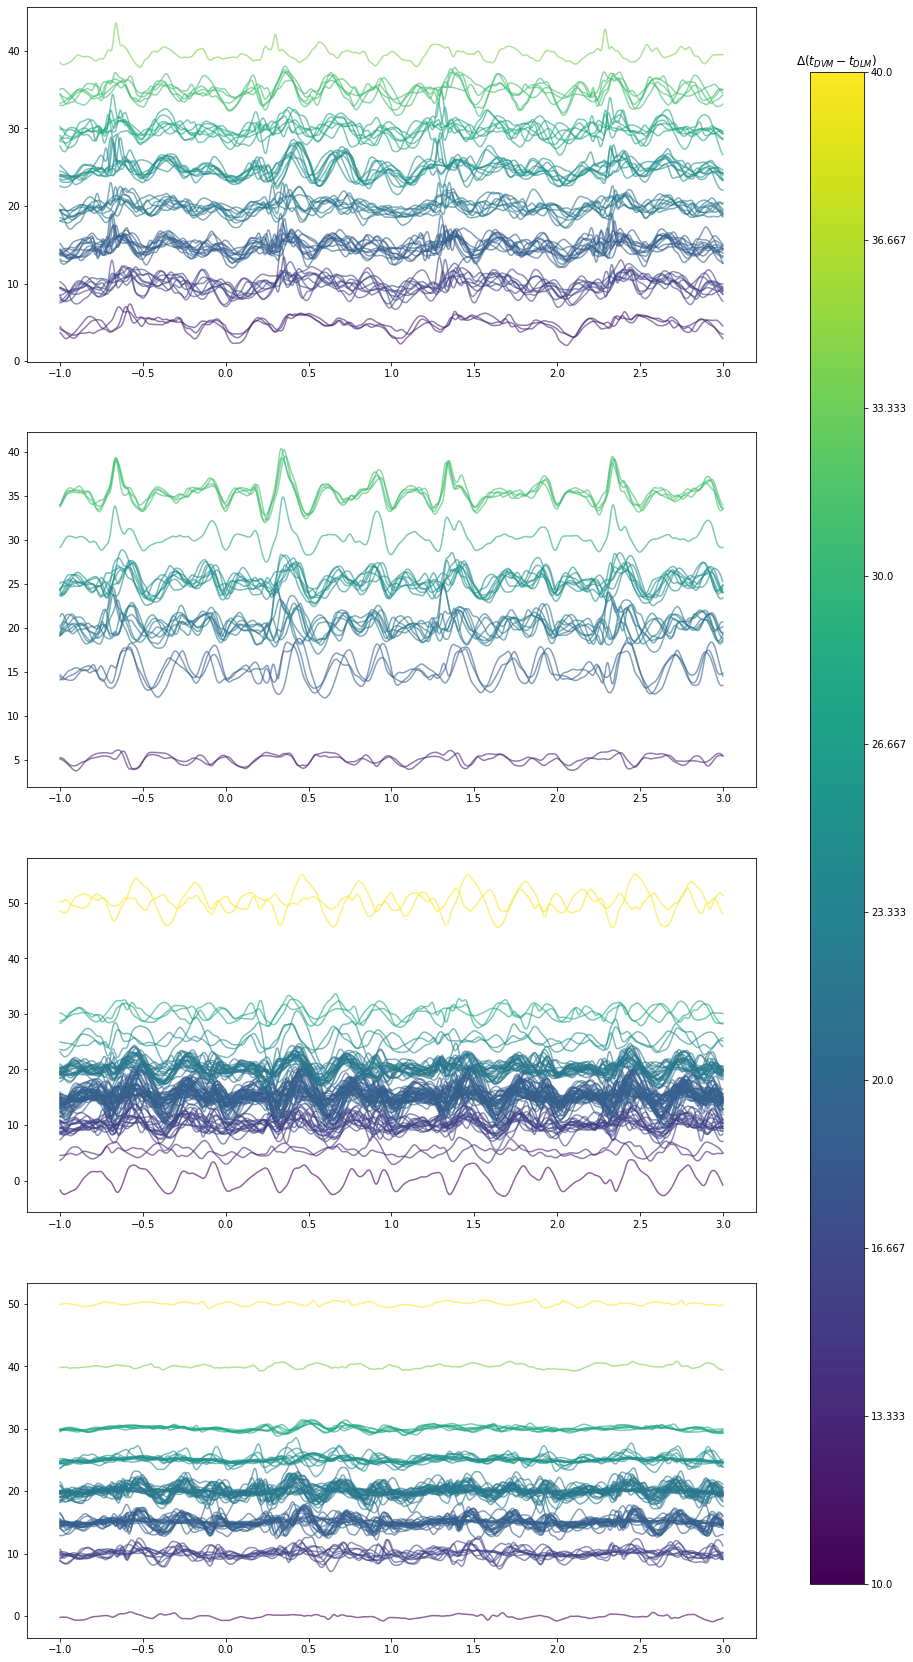

In [222]:
usewb = (-1, 3) # ignore all wingbeat except in this range
nbin = 10
# bins = np.linspace(-3, 16, nbin)
bins = np.linspace(10, 40, nbin)

fig, ax = plt.subplots(len(runDates), 1, figsize=(15,30))
viridis = cmx.get_cmap('viridis')

# Loop over dates
for di,d in enumerate(runDates):
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimphase<0.5)].copy()
    # Zero time, trim data to region around t=0
    dt.Time = dt.groupby(['date','pulse'], group_keys=False).apply(
        # lambda g: g['Time'] - g.loc[(g.wb==0), 'Time'].iloc[0])
        lambda g: g['Time'] - (g.loc[(g.wb==-1), 'Time'].iloc[0] + g.loc[g.wb==-1,'LDVM_fs'].iloc[0]/fsamp))
    # Preallocate/prepare for loop
    grouped_df = dt.groupby(['date','pulse'])
    ngroup, groupsize = grouped_df.ngroups, np.max(grouped_df.size())
    vals = []
    # Loop over each pulse, add to matrix
    for name, g in grouped_df:
        # thiscol = g.loc[g.wbstate=='stim', 'tdl'].iloc[0] - g.loc[g.wb==-1, 'tdl'].iloc[0]
        thiscol = g.loc[g.wbstate=='stim', 'tdl'].iloc[0]
        # thiscol = (g.loc[g.wbstate=='stim', 'LDVM_fs'].iloc[0] - g.loc[g.wbstate=='stim', 'LDLM_fs'].iloc[0])/len(g.loc[g.wbstate=='stim'])
        vals.append(thiscol)
        thisbin = np.digitize(thiscol, bins)
        ax[di].plot(g.phase+g.wb, g.mx+5*thisbin, color=viridis(thisbin/nbin), alpha=0.6)
        # ax[di].plot(g.Time, g.mx+5*thisbin, color=viridis(thisbin/nbin), alpha=0.6)
# Colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
mincol, maxcol = bins[0], bins[-1]
cbar = fig.colorbar(cmx.ScalarMappable(norm=None, cmap=viridis),
                    ticks=(bins-mincol)/(maxcol-mincol),
                    cax=cbar_ax)
cbar.ax.set_yticklabels([str(round(x,3)) for x in bins])
cbar.ax.set_title(r'$\Delta (t_{DVM}-t_{DLM})$')

# PCA of torque waveforns

Text(0, 0.5, 'Explained Variance')

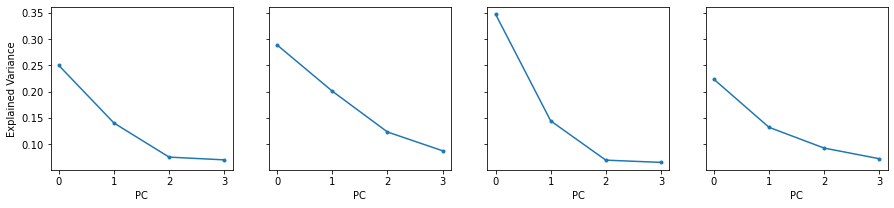

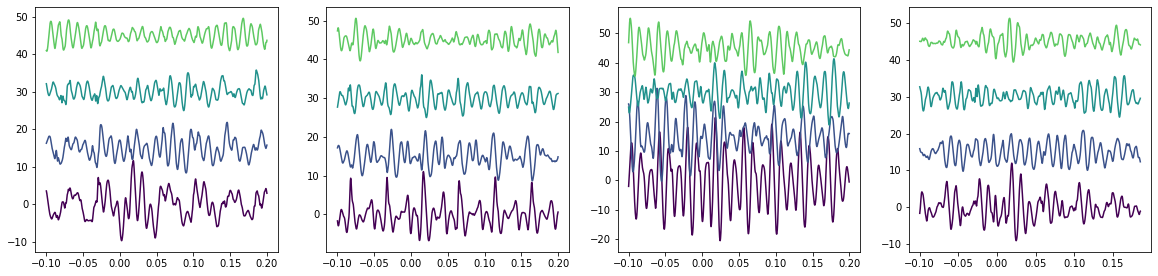

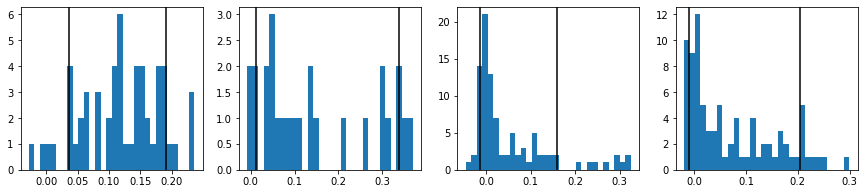

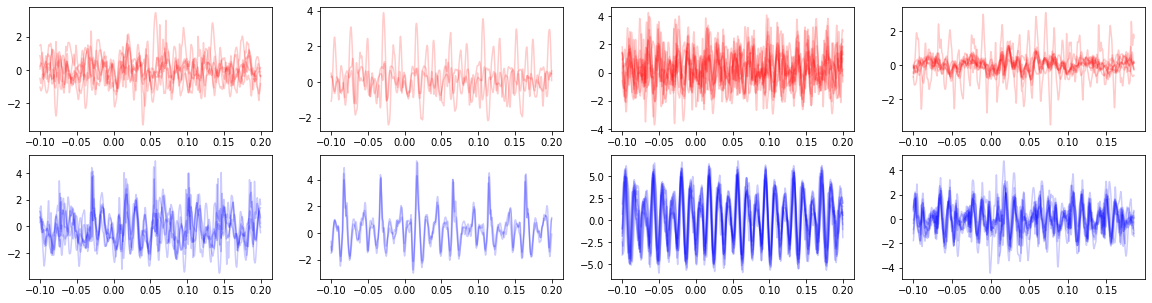

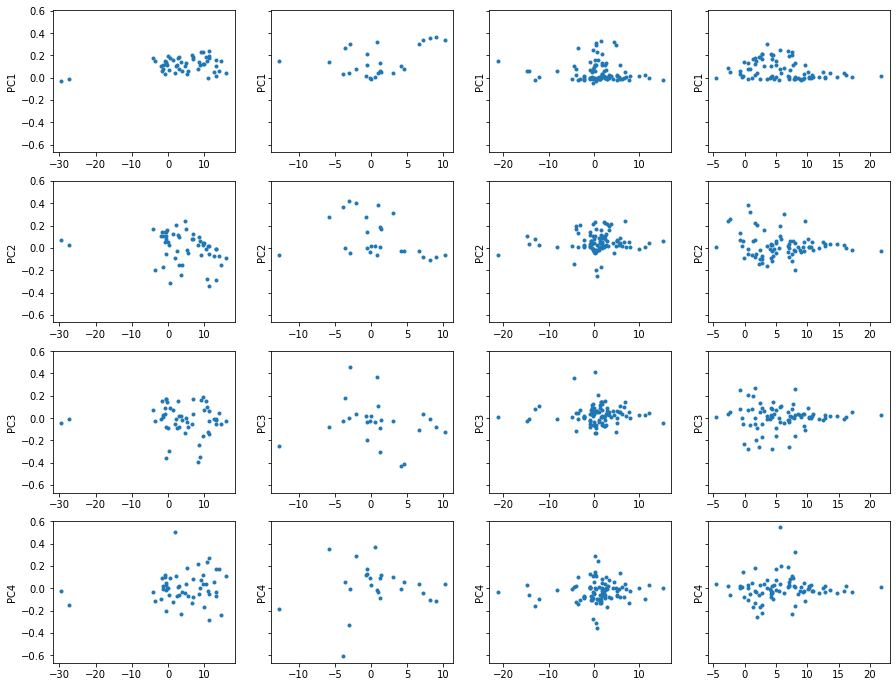

In [9]:
ncomp = 4
usewb = (-3, 6) # ignore all wingbeat except in this range
usewindow = (-100, 200) # ms, window to actually observe around zero'd time

# Figure parameters
viridis = cmx.get_cmap('viridis')
fw, fh = 15, 3
# Create figures
fev, axev = plt.subplots(1, len(runDates), figsize=(fw,fh), sharey=True) # explained variance
fpc, axpc = plt.subplots(1, len(runDates), figsize=(20,4.5)) # main PC's
fpc1dist, axpc1dist = plt.subplots(1, len(runDates), figsize=(fw,fh)) # PC1 distribution
fpc1, axpc1 = plt.subplots(2, len(runDates), figsize=(20,5)) # PC1 deciles
figstim, axstim = plt.subplots(len(runDates), ncomp, figsize=(15,12), sharey=True) # PC loadings against stimulus variable (DLM-DVM timing, for instance)
# Loop over dates
for di,d in enumerate(runDates):
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimphase<0.5)].copy()
    # Zero time, trim data to region around t=0
    dt.Time = dt.groupby(['date','pulse'], group_keys=False).apply(
        lambda g: g['Time'] - g.loc[(g.wb==0), 'Time'].iloc[0])
        # lambda g: g['Time'] - (g.loc[(g.wb==-1), 'Time'].iloc[0] + g.loc[g.wb==-1,'LDVM_fs'].iloc[0]/fsamp))
    dt = dt.loc[(dt.Time>=usewindow[0]/1000) & (dt.Time<=usewindow[1]/1000)]
    # Group dataframe, prepare for loop
    grouped_df = dt.groupby(['date','pulse'])
    ngroup, groupsize = grouped_df.ngroups, np.max(grouped_df.size())
    mat = np.full((ngroup,groupsize), np.nan)
    stimvar = np.zeros(ngroup)
    # Loop over each pulse, add to matrix
    for i, (name, g) in enumerate(grouped_df):
        vec = g
        mat[i,0:len(vec)] = vec.mx
        stimvar[i] = g.loc[g.wbstate=='stim', 'tdl'].iloc[0] - g.loc[g.wb==-1, 'tdl'].iloc[0]
        # stimvar[i] = g.loc[g.wbstate=='stim', 'tdl'].iloc[0]
        # stimvar[i] = g.loc[g.wbstate=='stim', 'stimphase'].iloc[0]
    # Create time vector 
    # tvec = np.linspace(0, (mat.shape[1]-1)/fsamp, mat.shape[1])
    tvec = np.arange(usewindow[0]/1000, usewindow[1]/1000, 1/fsamp)
    # Trim nan points (in the future can interpolate nans?)
    tvec = tvec[~np.isnan(mat).any(axis=0)]
    mat = mat[:, ~np.isnan(mat).any(axis=0)]

    # Take PCA
    pca = PCA(n_components=ncomp)
    pc = pca.fit_transform(mat.T)
    
    # Plot explained variance
    axev[di].plot(pca.explained_variance_ratio_, '.-')
    axev[di].set_xlabel('PC')
    # Plot main PC's
    for i in range(pc.shape[1]):
        axpc[di].plot(tvec, pc[:,i]+i*15, color=viridis(i/pc.shape[1]))
    # Plot distribution of PC1
    deciles = np.percentile(pca.components_[0,:], np.arange(0, 100, 10))
    axpc1dist[di].hist(pca.components_[0,:], bins=30)
    axpc1dist[di].axvline(x=deciles[1], color='black')
    axpc1dist[di].axvline(x=deciles[-1], color='black')
    # Get which traces are in lower and upper percentile, plot those
    for j in np.where(pca.components_[0,:]<=deciles[1])[0]:
        axpc1[0,di].plot(tvec, mat[j,:], color='red', alpha=0.2)
    for j in np.where(pca.components_[0,:]>=deciles[-1])[0]:
        axpc1[1,di].plot(tvec, mat[j,:], color='blue', alpha=0.2)
    
    # Plot stimvar against each PC
    for i in range(ncomp):
        axstim[i,di].plot(stimvar, pca.components_[i,:], '.')
    # Plot labels
    # if di==(len(runDates)-1):
    for i in range(ncomp):
        axstim[i,di].set_ylabel('PC'+str(i+1))
    # axstim[di,0].set_ylabel(r'$\Delta (t_{DVM}-t_{DLM})$')
# Labels
axev[0].set_ylabel('Explained Variance')


# Spike-Triggered Mean Pitch

20210803_1
20210816
20210817_1
20210818_1


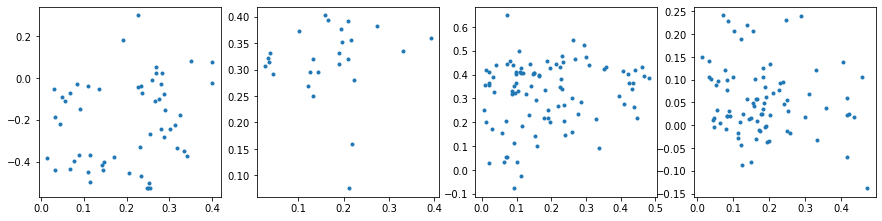

In [26]:
window = 500 #samples

fig, ax = plt.subplots(1, len(runDates), figsize=(15,3.5))
# Loop over dates
for di,d in enumerate(runDates):
    print(d)
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimphase<0.5)].copy()
    # Zero time, trim data to region around t=0, change phase to be unique for each wb
    dt.Time = dt.groupby(['date','pulse'], group_keys=False).apply(
        # lambda g: g['Time'] - g.loc[(g.wb==0), 'Time'].iloc[0])
        lambda g: g['Time'] - (g.loc[(g.wb==-1), 'Time'].iloc[0] + g.loc[g.wb==-1,'LDVM_fs'].iloc[0]/fsamp))
    # Generate y axis vector
    dt['yvar'] = 0
    dt['yvar'] = dt.groupby(['date','pulse'], group_keys=False).apply(
        lambda g: g.yvar + g.stimphase)
        # lambda g: g.yvar + (g.loc[g.wbstate=='stim', 'tdl'].iloc[0] - g.loc[g.wb==-1, 'tdl'].iloc[0]))
        # lambda g: g.yvar + g.loc[g.wbstate=='stim', 'tdl'].iloc[0])
        # lambda g: g.yvar + (g.loc[g.wbstate=='stim', 'LDVM_fs'].iloc[0] - g.loc[g.wbstate=='stim', 'LDLM_fs'].iloc[0])/len(g.loc[g.wbstate=='stim']))
    dt = dt.loc[~np.isnan(dt.yvar)]
    
    # make dataframe subset
    dt = dt.loc[dt.Time>=0]
    dt = dt.groupby(['date','pulse']).aggregate({
        'mx' : lambda g: np.mean(g.iloc[0:window]),
        'yvar' : 'first'
    })
    
    ax[di].plot(dt.yvar, dt.mx, '.')


# $(t_{DVM}-t_{DLM})$ vs stimphase:
How well does the actual stimulus phase connect to DVM-DLM timing difference? Not important, but just curious

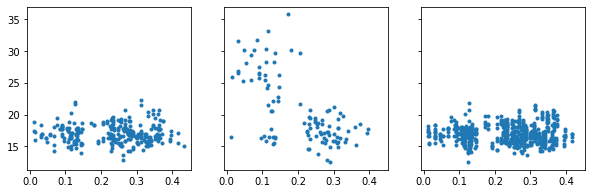

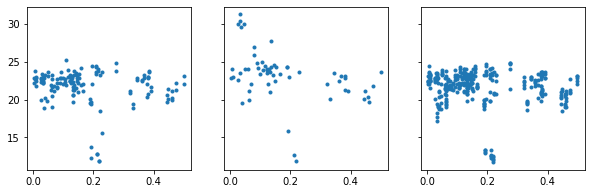

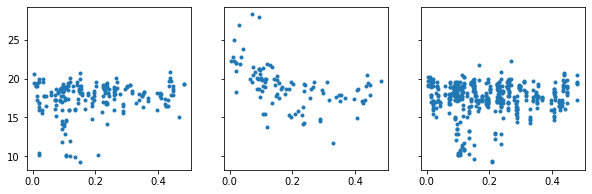

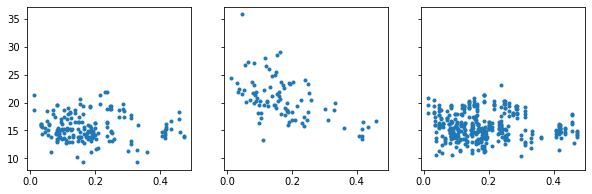

In [163]:
ncomp = 4
usewb = (-2, 6)

aggdict = {}
aggdict['wbstate'] = 'first'
aggdict['stimphase'] = 'first'
aggdict['tdl'] = 'first'
aggdict['tdr'] = 'first'

# Loop over dates
for d in runDates:
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimphase<0.5)].copy()
    
    g = dt.groupby(['date','pulse','wb']).aggregate(aggdict)
    
    fig, ax = plt.subplots(1, 3, figsize=(10,3), sharex=True, sharey=True)
    for i,state in enumerate(['pre','stim','post']):
        dsub = g.loc[g.wbstate==state]
        ax[i].plot(dsub.stimphase, dsub.tdl, '.')

# Quick look: Does wingbeat frequency/period vary with stimulation-induced change in spike time?

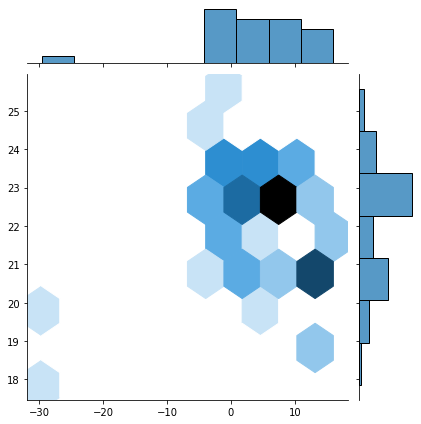

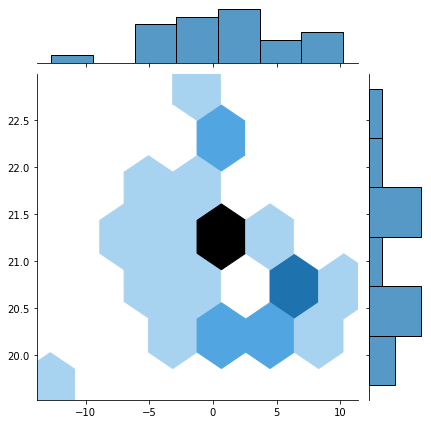

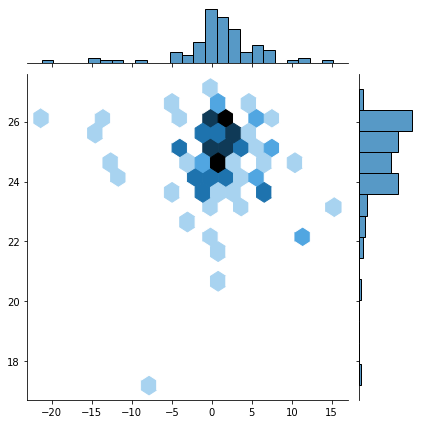

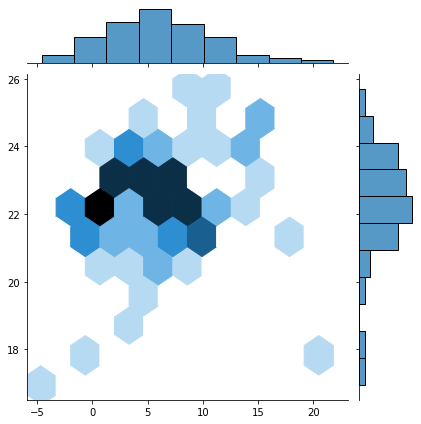

In [110]:
usewb = (-2, 2) # ignore all wingbeat except in this range
# Loop over dates
for di,d in enumerate(runDates):
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimphase<0.5)].copy()
    # Preallocate/prepare for loop
    grouped_df = dt.groupby(['date','pulse'])
    deltaT = []
    wbf = []
    # Loop over each pulse, add to matrix
    for name, g in grouped_df:
        deltaT.append(g.loc[g.wbstate=='stim', 'tdl'].iloc[0] - g.loc[g.wb==-1, 'tdl'].iloc[0])
        # thiscol = g.loc[g.wbstate=='stim', 'tdl'].iloc[0]
        # thiscol = (g.loc[g.wbstate=='stim', 'LDVM_fs'].iloc[0] - g.loc[g.wbstate=='stim', 'LDLM_fs'].iloc[0])/len(g.loc[g.wbstate=='stim'])
        wbf.append(1/(len(g.loc[g.wbstate=='stim'])/fsamp))
    sns.jointplot(x=deltaT, y=wbf, kind='hex')

# How wingbeat period/frequency ($F_z$ cycles) is impacted by stimulation

Text(0.5, 1.0, '$\\Delta (t_{DVM}-t_{DLM})$')

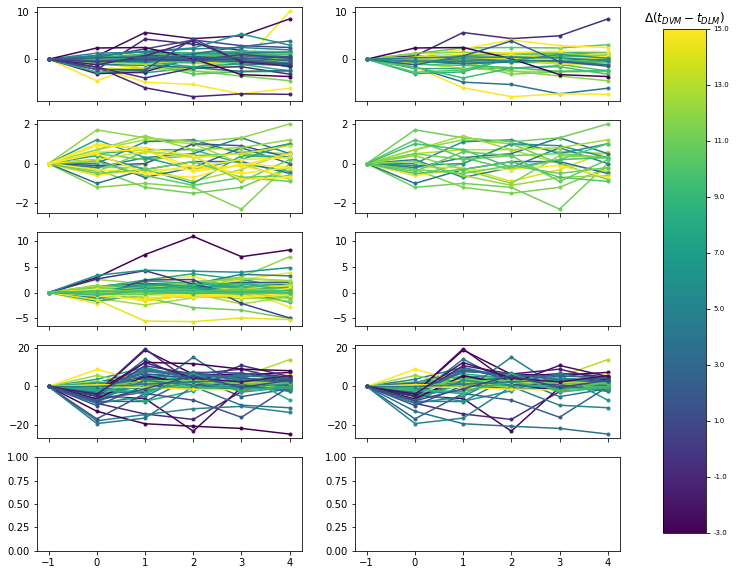

In [5]:
plt.close('all')
usewb = (-1, 5) # ignore all wingbeat except in this range
fig, ax  = plt.subplots(len(runDates), 2, sharex=True, figsize=(12,10))
# Loop over dates
for ind,d in enumerate(runDates):
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimphase<0.5)].copy()
    # Color setup
    viridis = cmx.get_cmap('viridis')
    maxcol, mincol = 15, -3
    # Zero time
    dt.Time = dt.groupby(['date','pulse'], group_keys=False).apply(
        lambda g: g['Time'] - g.loc[(g.wb==0), 'Time'].iloc[0])
    # Preallocate/prepare for loop
    grouped_df = dt.groupby(['date','pulse'])
    ngroup, groupsize = grouped_df.ngroups, np.max(grouped_df.size())
    # Loop over each pulse, add to matrix
    for name, g in dt.groupby(['date','pulse']):
        # Loop over left and right
        for lri,lr in enumerate(['l','r']):
            thiscol = g.loc[g.wbstate=='stim', 'td'+lr].iloc[0] - g.loc[g.wb==-1, 'td'+lr].iloc[0]
            # thiscol = g.loc[g.wbstate=='stim', 'tdr'].iloc[0]
            # thiscol = (g.loc[g.wbstate=='stim', 'LDVM_fs'].iloc[0] - g.loc[g.wbstate=='stim', 'LDLM_fs'].iloc[0])/len(g.loc[g.wbstate=='stim'])
            dg = g.groupby('wb').size()
            ax[ind,lri].plot(dg.index, (dg.values-dg.values[0])/10, '.-',
                                color=viridis((maxcol-thiscol)/(maxcol-mincol)))
# Labels
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
tickrange = np.linspace(mincol, maxcol, 10)
cbar = fig.colorbar(cmx.ScalarMappable(norm=None, cmap=viridis),
                    ticks=(tickrange-mincol)/(maxcol-mincol),
                    cax=cbar_ax)
cbar.ax.set_yticklabels([str(round(x,3)) for x in tickrange], fontsize=7)
cbar.ax.set_title(r'$\Delta (t_{DVM}-t_{DLM})$')

# How DLM-DVM timing changes after stimulation

/var/folders/wk/44b_fwgs06q9gfdjtfs124640000gp/T/ipykernel_34634/3121290231.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axd[len(runDates)-1].set_xticklabels(


[Text(-4.0, 0, '-4--3'),
 Text(-3.0, 0, '-3--2'),
 Text(-2.0, 0, '-2--1'),
 Text(-1.0, 0, '-1-0'),
 Text(0.0, 0, '0-1'),
 Text(1.0, 0, '1-2'),
 Text(2.0, 0, '2-3'),
 Text(3.0, 0, '3-4'),
 Text(4.0, 0, '4-5')]

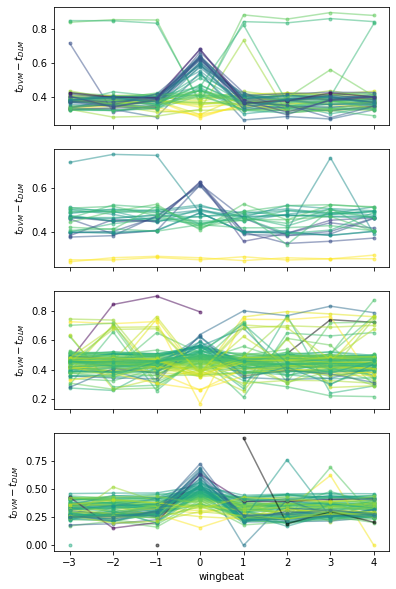

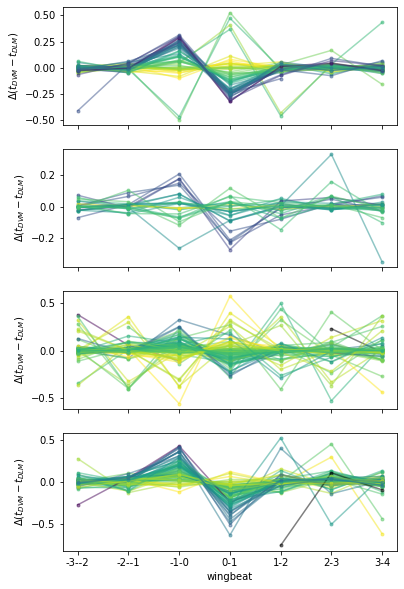

In [27]:
usewb = (-3, 5) # ignore all wingbeat except in this range
viridis = cmx.get_cmap('viridis')
maxcol, mincol = 36, 13
fig, ax  = plt.subplots(len(runDates), 1, sharex=True, figsize=(6,10))
figd, axd  = plt.subplots(len(runDates), 1, sharex=True, figsize=(6,10))
# Loop over dates
for ind,d in enumerate(runDates):
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimphase<0.5)].copy()
    # Loop over each pulse, add to matrix
    for name, g in dt.groupby(['date','pulse']):
        thiscol = g.loc[g.wbstate=='stim', 'tdl'].iloc[0]
        dg = g.groupby('wb').aggregate({'wb' : 'first',
                                        'tdl' : 'first'})
        ax[ind].plot(dg.wb, dg.tdl, '.-',
                     color=viridis((maxcol-thiscol)/(maxcol-mincol)),
                     alpha=0.5)
        axd[ind].plot(dg.wb.to_numpy()[:-1], np.diff(dg.tdl), '.-',
                      color=viridis((maxcol-thiscol)/(maxcol-mincol)),
                      alpha=0.5)
    ax[ind].set_ylabel(r'$t_{DVM}-t_{DLM}$')
    axd[ind].set_ylabel(r'$\Delta (t_{DVM}-t_{DLM})$')
# Labels
ax[len(runDates)-1].set_xlabel('wingbeat')
axd[len(runDates)-1].set_xlabel('wingbeat')
axd[len(runDates)-1].set_xticklabels(
    labels=[str(x)+'-'+str(x+1) for x in np.arange(usewb[0]-1,usewb[1])])


To illustrate what's going on in weird trials let's pick a few really odd ones:

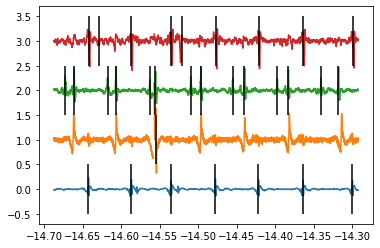

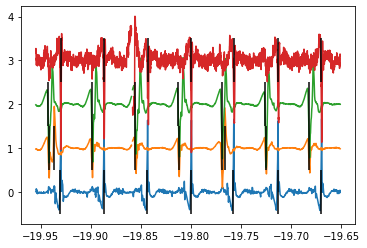

In [42]:
# Really high delta t:
dt = df.loc[
    (df.wb>=usewb[0]) & 
    (df.wb<usewb[1]) & 
    (df.stimphase<0.5) & 
    (df.date=='20210803_1') &
    (df.pulse==19)].copy()
plt.figure()
for i,m in enumerate(channelsEMG):
    plt.plot(dt.Time, dt[m]+i)
    plt.vlines(x=dt.loc[dt[m+'_st'], 'Time'], ymin=i-0.5, ymax=i+0.5, color='black', zorder=3)
# Really low delta t:
dt = df.loc[
    (df.wb>=usewb[0]) & 
    (df.wb<usewb[1]) & 
    (df.stimphase<0.5) & 
    (df.date=='20210816') &
    (df.pulse==26)].copy()
plt.figure()
for i,m in enumerate(channelsEMG):
    plt.plot(dt.Time, dt[m]+i)
    plt.vlines(x=dt.loc[dt[m+'_st'], 'Time'], ymin=i-0.5, ymax=i+0.5, color='black', zorder=3)

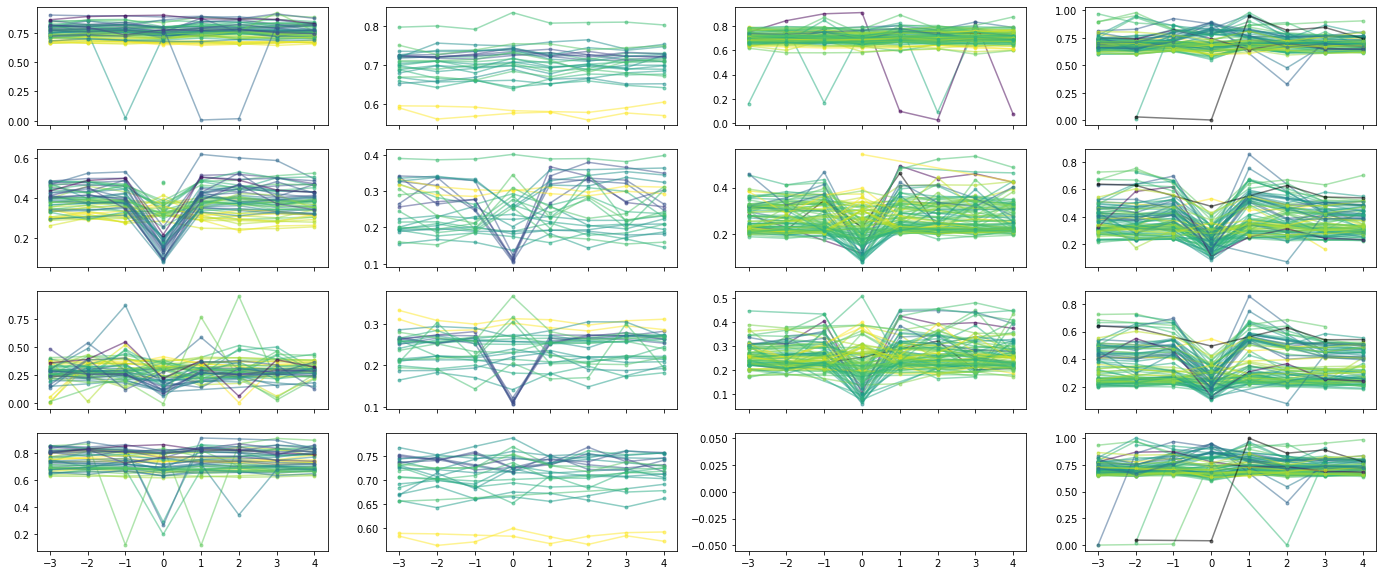

In [221]:
usewb = (-3, 5) # ignore all wingbeat except in this range
viridis = cmx.get_cmap('viridis')
maxcol, mincol = 36, 13

aggdict = {'stimphase' : 'first',
           'wbstate' : 'first',
           'tdl' : 'first'}
for m in channelsEMG:
    aggdict[m+'_fs'] = lambda x: x.iloc[0]/len(x)


fig, ax  = plt.subplots(len(runDates), 4, sharex=True, figsize=(24,10))
# figd, axd  = plt.subplots(len(runDates), 4, sharex=True, figsize=(24,10))
# Loop over dates
for ind,d in enumerate(runDates):
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimphase<0.5)].copy()
    dt = dt.groupby(['date','pulse','wb']).aggregate(aggdict).reset_index()
    # Loop over each pulse, add to matrix
    for name, g in dt.groupby(['date','pulse']):
        thiscol = g.loc[g.wbstate=='stim', 'tdl'].iloc[0]
        for mi,m in enumerate(channelsEMG):
            inds = g[m+'_fs']!=0
            ax[mi,ind].plot(g.loc[inds,'wb'], g.loc[inds, m+'_fs'], '.-',
                        color=viridis((maxcol-thiscol)/(maxcol-mincol)),
                        alpha=0.5)

# dt = df.loc[(df['LDVM_st'] | df['LDLM_st'] | df['RDLM_st']| df['RDVM_st']) & 
dt = df.loc[(df.wb>=usewb[0]) & 
            (df.wb<usewb[1]) & 
            (df.stimphase<0.5)].copy()
dt = dt.groupby(['date','pulse','wb']).aggregate(aggdict)


# dt = dt.melt(id_vars=['date','pulse','wb'],value_vars=['LDVM_fs','LDLM_fs','RDLM_fs','RDVM_fs'])
# grid = sns.FacetGrid(dt, row='date',col='variable', margin_titles=True)
# grid.map(sns.boxplot, 'wb', 'value')

# General notes

- Could use a more general-purpose function to split cycles by any variable or criterion, and return a new dataframe column of wingbeats from that cycle-splitting metric. What if I want to use the hilbert transform of a 20Hz bandpass filtered $M_x$ (or any force or torque)? What about aligning by first or second spike of a given muscle?
- Need way to take stimulation delays that are very long and loop them back around, offset. 

# Ideas

- Align by _mean_ spike time for pre-stim spikes